Lybraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,accuracy_score,ConfusionMatrixDisplay,confusion_matrix,precision_score,recall_score,roc_curve,roc_auc_score,balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from tensorflow import keras
import datetime
from dataclasses import dataclass
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.ndimage import gaussian_filter1d
from itertools import combinations as comb
from pyts.image import RecurrencePlot
import PIL
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,StratifiedKFold
from scikeras.wrappers import KerasClassifier
import keras_tuner
from unidecode import unidecode
from keras_tuner_cv.outer_cv import OuterCV



### EDA

In [3]:
train_path='data/test_motion_data.csv'
test_path='data/train_motion_data.csv'

#### Train data

In [4]:
train_data=pd.read_csv(train_path)
train_data.head(1)

AccX      AccY      AccZ  GyroX  GyroY  GyroZ       Class  Timestamp
0  0.758194 -0.217791  0.457263    0.0    0.0    0.0  AGGRESSIVE     818922

In [5]:
train_data.describe()

AccX         AccY         AccZ        GyroX        GyroY  \
count  3084.000000  3084.000000  3084.000000  3084.000000  3084.000000   
mean      0.106234    -0.131791     0.045011     0.003192     0.001452   
std       0.968089     0.904398     0.997625     0.066636     0.120963   
min      -4.854163    -7.621754    -6.106982    -0.514959    -1.309466   
25%      -0.408916    -0.625868    -0.461438    -0.024435    -0.045739   
50%       0.051892    -0.096929     0.054154     0.001222    -0.000993   
75%       0.579148     0.393118     0.575119     0.028100     0.043601   
max       5.864980     4.308813     5.564037     1.490511     1.707598   

             GyroZ      Timestamp  
count  3084.000000    3084.000000  
mean      0.011472  819830.000324  
std       0.113535     525.760733  
min      -0.976315  818922.000000  
25%      -0.027031  819338.000000  
50%       0.002291  819832.500000  
75%       0.035888  820292.250000  
max       0.719447  820709.000000

In [6]:
train_data.isna().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [7]:
train_data=train_data.sort_values(by='Timestamp')

In [8]:
train_data.Timestamp.unique().shape

(1667,)

There are roughly 2 measurements per second

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3084 entries, 0 to 3083
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3084 non-null   float64
 1   AccY       3084 non-null   float64
 2   AccZ       3084 non-null   float64
 3   GyroX      3084 non-null   float64
 4   GyroY      3084 non-null   float64
 5   GyroZ      3084 non-null   float64
 6   Class      3084 non-null   object 
 7   Timestamp  3084 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 216.8+ KB


In [10]:
train_data.Timestamp.value_counts().describe()

count    1667.000000
mean        1.850030
std         0.357149
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Timestamp, dtype: float64

It proves that there is not a single timestamp that is replicated many times, while the rest just appear once.

In [11]:
train_data.columns

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')

In [12]:
train_data['Timestamp']=train_data['Timestamp'].astype('int')

train_data['Class']=train_data['Class'].astype('category')
train_data['class_code']=train_data['Class'].cat.codes

In [13]:
var_columns=['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']
label_columns=['class_code','Class']

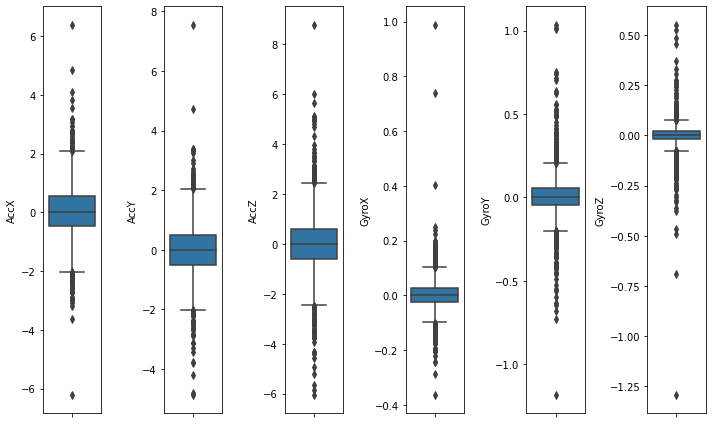

In [14]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

There are a lot of outliers, e.i., There are many measurements in the same timestamp that are desagreeing badly. However, it might be due to is amplitude. Then lets take a look in the boxplot normalized. 

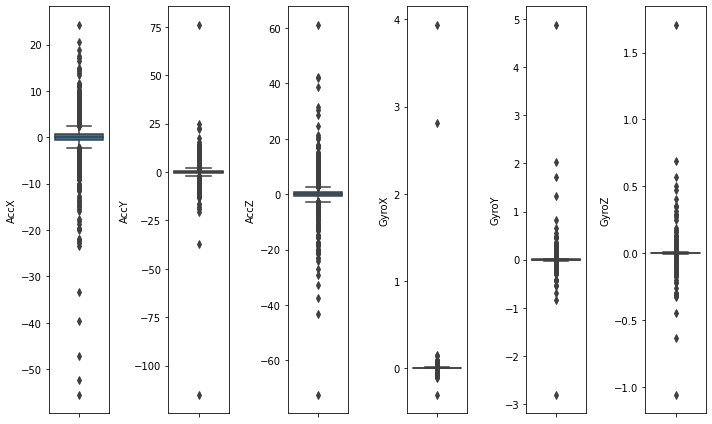

In [15]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

The gyroscope data is not desagreeing much. But, the accelaration data has massive desagreement in some measuments. 
 


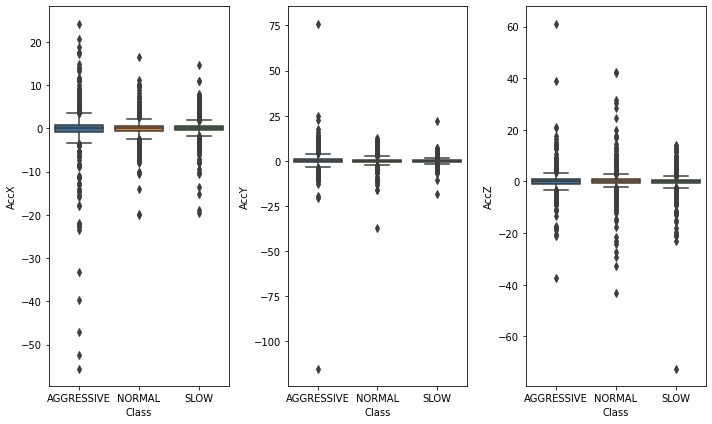

In [16]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
diff=diff.reset_index().merge(train_data.drop_duplicates('Timestamp')[['Timestamp','Class']],right_on='Timestamp',left_on='index')
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(1,len(used_columns),figsize=(10,6))
for column,ax in zip(used_columns,axes.flatten()):
    sns.boxplot(data=diff,y=column,ax=ax,x='Class')
plt.tight_layout()

level of agreeament

[1]Bland, J. Martin, and DouglasG Altman. "Statistical methods for assessing agreement between two methods of clinical measurement." The lancet 327.8476 (1986): 307-310.


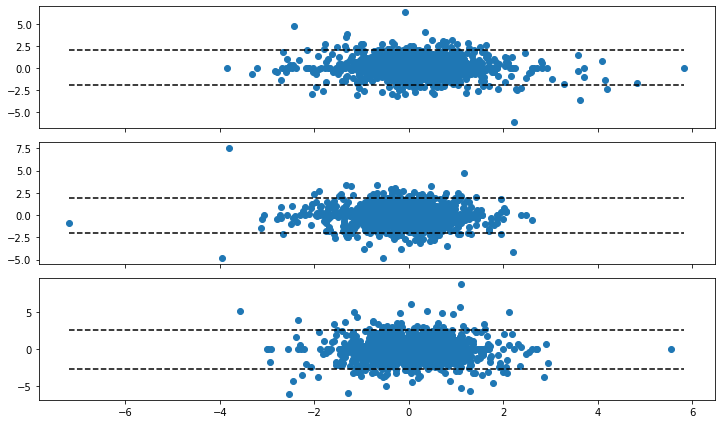

In [17]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(measument1+measument2)*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])
    ax.hlines(np.mean(diff[column])+2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
    ax.hlines(np.mean(diff[column])-2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
plt.tight_layout()


Even though, the data are quite odd and shows significant difference, Using [1] one might argui that both data agree.

Also, With this it seems that there is not a specific range where the data desagree more.

Since both measures may have different signs I will be taken the mean of its module, I wonder if there is some behaviour hidden due it. 

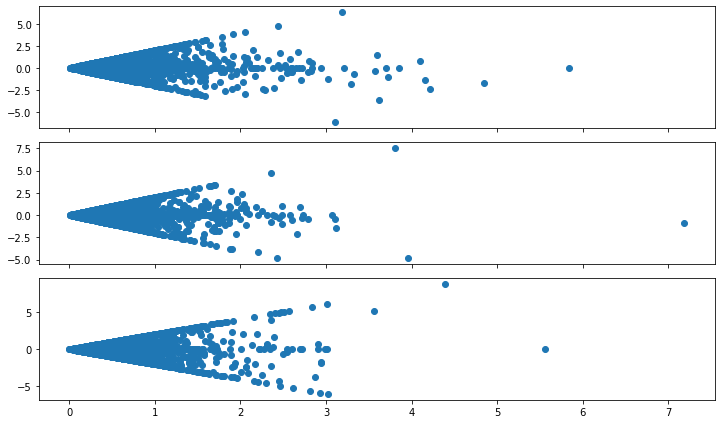

In [18]:
index=(train_data.Timestamp.value_counts()>1).index
measument1=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(np.abs(measument1)+np.abs(measument2))*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])

plt.tight_layout()


Adding new features.

In [19]:
train_data['Acc_mod']=0.5*(train_data['AccX']**2+train_data['AccY']**2+train_data['AccZ']**2)
var_columns.append('Acc_mod')

Dataset balance

<AxesSubplot:>

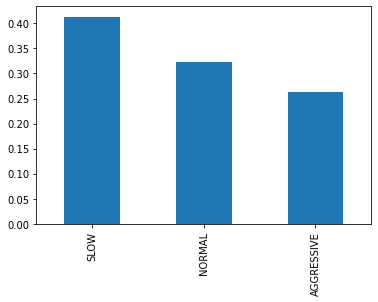

In [20]:
train_data['Class'].value_counts(normalize=True).plot(kind='bar')

Data aumentation

In [21]:
missing_seconds=set(train_data['Timestamp'].unique()).difference(set(range(train_data['Timestamp'].min(),train_data['Timestamp'].max()+1)))
missing_seconds

set()

With this we ensure the signal continuity

Bellow, it has been created some code for fixing some possible descontinuity

In [22]:
avaible_seconds=train_data.Timestamp.unique()

for second in missing_seconds:
    new_index=len(train_data)+1
    train_data.loc[new_index,['Timestamp']]=[second]
    train_data.loc[new_index,var_columns]=[np.nan]*len(var_columns)
   
    for offset in range(1,11):
        filled=False
        if second-offset in avaible_seconds:
            train_data.loc[new_index,label_columns]=train_data.drop_duplicates('Timestamp').set_index('Timestamp').loc[second-offset,label_columns]
            filled=True
            break
        elif second+offset in avaible_seconds:
            train_data.loc[new_index,label_columns]=train_data.drop_duplicates('Timestamp').set_index('Timestamp').loc[second+offset,label_columns]
            filled=True
            break

    if not filled: print('Method did not work')
    train_data.loc[new_index,label_columns]=[np.nan]*len(label_columns)
    
train_data=train_data.sort_values('Timestamp').reset_index(drop=True)
train_data[var_columns]=train_data[var_columns].interpolate(method='polynomial',order=5)[var_columns]=train_data[var_columns].interpolate(method='linear')

Observing the data as a signal

In [23]:
train_data['Class'].map({'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}).value_counts()

green    1273
blue      997
red       814
Name: Class, dtype: int64

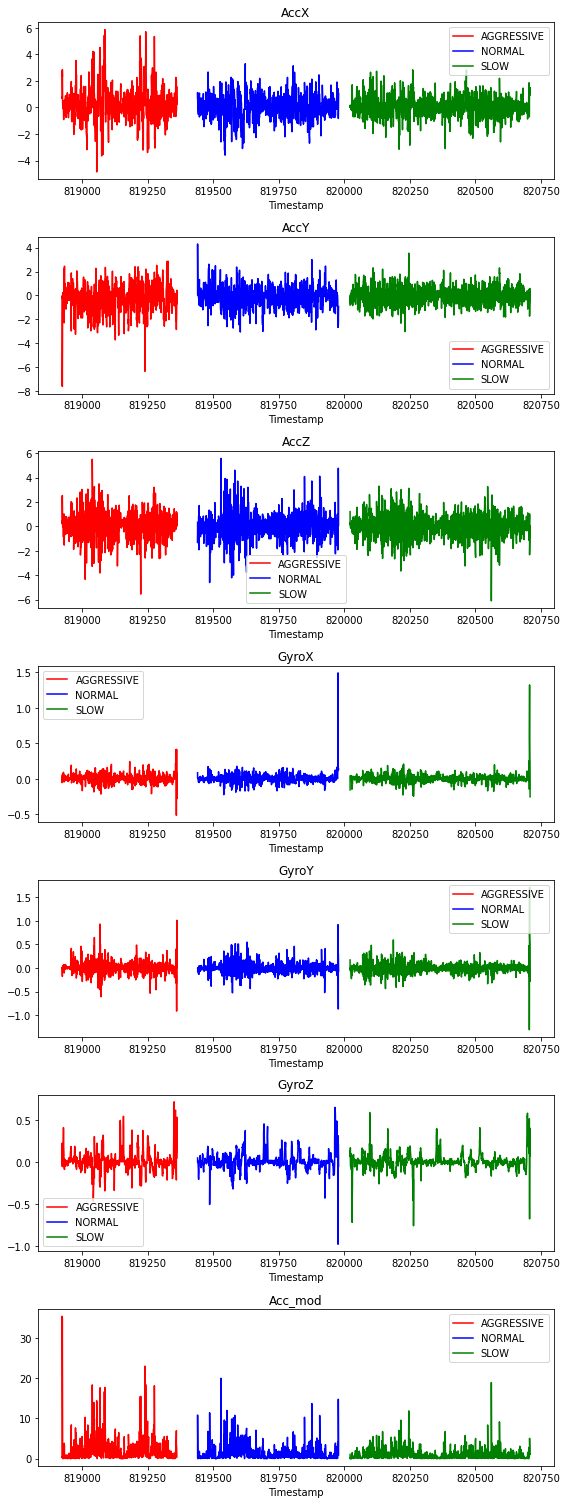

In [24]:
fig,axes=plt.subplots(len(var_columns),1,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes.flatten(),var_columns):
    grouped=train_data.groupby('Class')
    color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
    for key,group in grouped:
        group.plot(ax=ax,x='Timestamp',y=column,label=key,color=color[key])
    ax.set_title(column)
plt.tight_layout()

FFT

In [25]:
def fourier_analysis(data,fft_ax,psd_ax,prefix=''):
    fft=np.fft.fft(data)
    freq=np.fft.fftfreq(len(data),d=1)

    fft_ax.plot(freq,fft.real,color='red',alpha=0.5,label='real')
    fft_ax.plot(freq,fft.imag,color='blue',alpha=0.6,label='imag')
    fft_ax.set_xlim(left=0)
    fft_ax.set_title(prefix+' FFT')
    fft_ax.legend()
    psd=(1/len(data))*(fft.real**2+fft.imag**2)
    psd_ax.set_title(prefix+' PSD')
    psd_ax.plot(freq,psd,color='blue',alpha=0.7)
    psd_ax.set_xlim(left=-0.01)
    

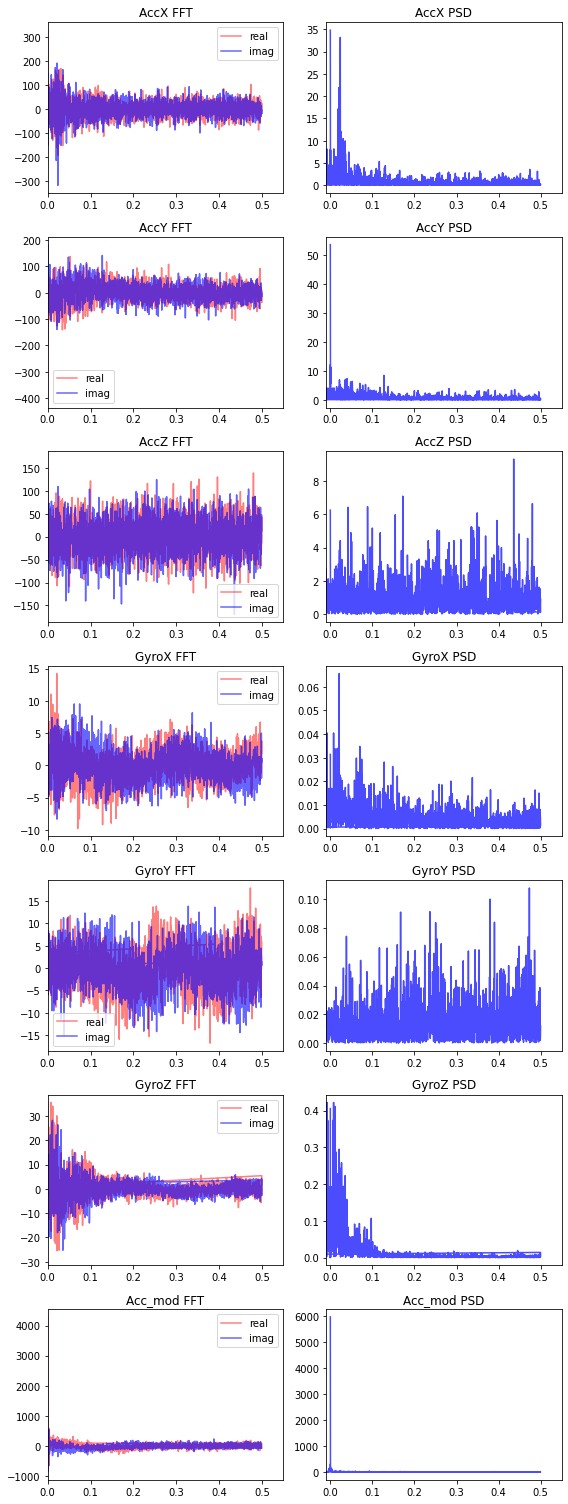

In [26]:
fig,axes=plt.subplots(len(var_columns),2,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    fourier_analysis(train_data[column],ax[0],ax[1],prefix=column)
plt.tight_layout()

Looking the fft of each class, since showed before, there are three continuos periods in data

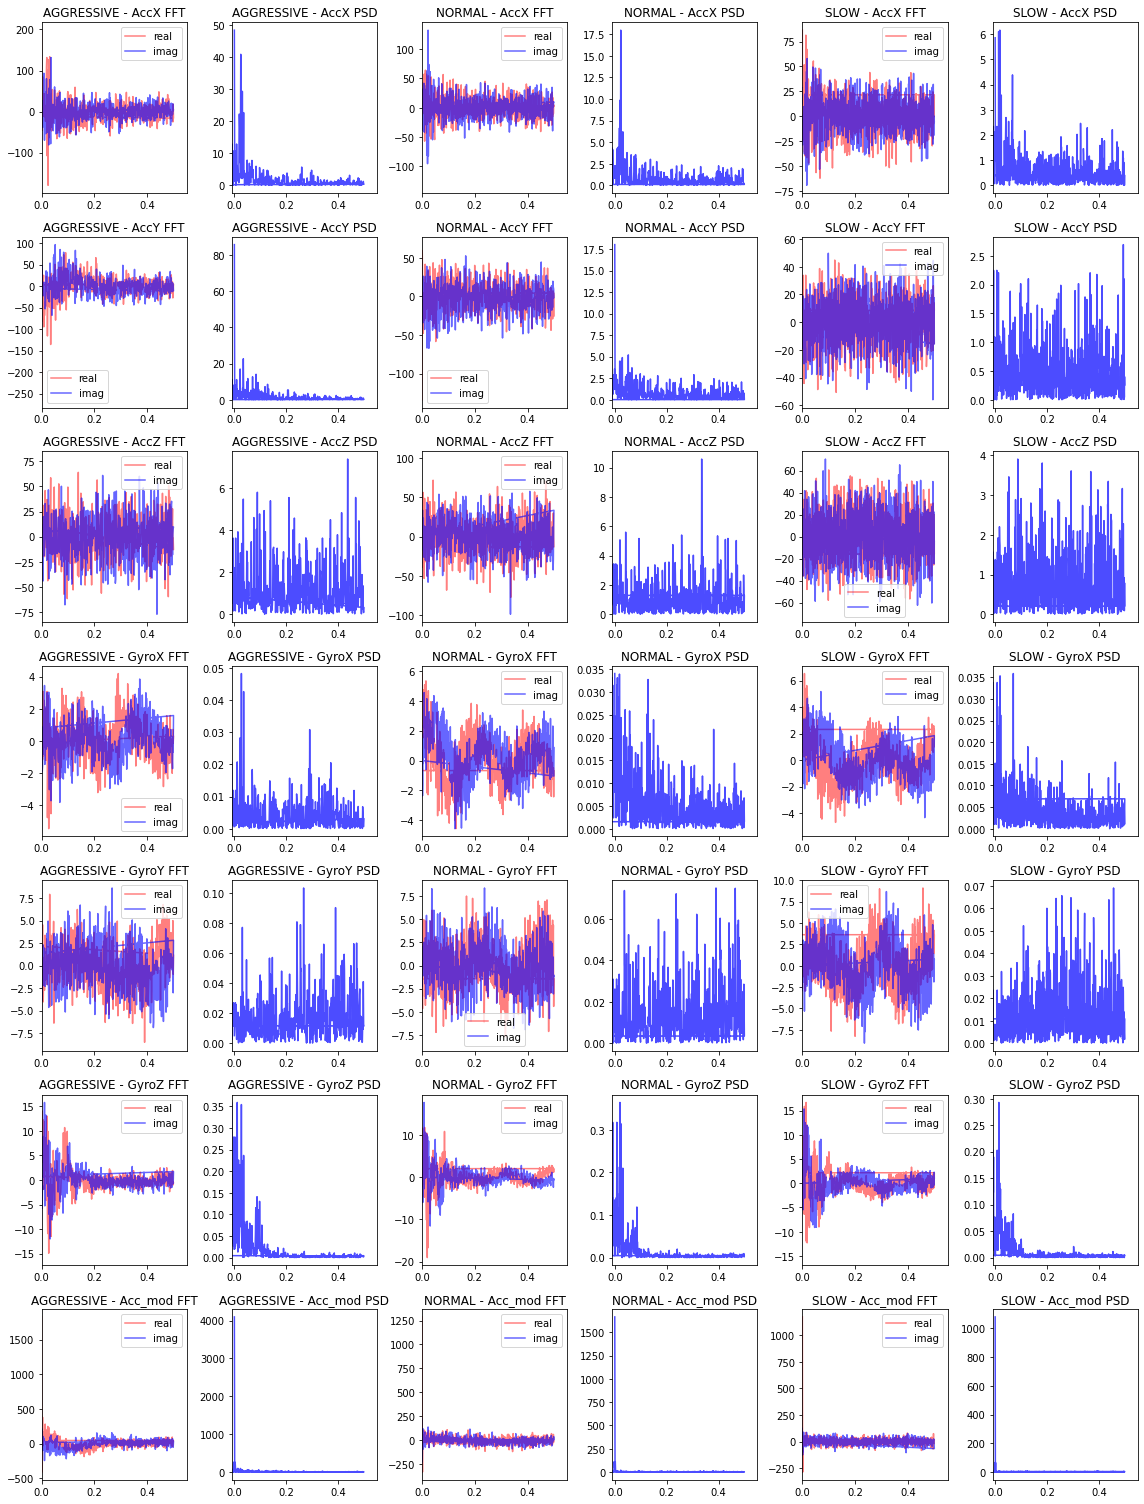

In [27]:
fig,axes=plt.subplots(len(var_columns),6,figsize=(16,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    grouped=train_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=grouped.get_group(key)[column]
        fourier_analysis(data,ax[groupd_index*2],ax[groupd_index*2+1],prefix=f'{key} - {column}')
plt.tight_layout()

spectogram

In [28]:
def spectogram_analysis(data,ax,prefix=''):
    f, t, Sxx = signal.spectrogram(data, 1)
    im=ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(prefix)
    plt.colorbar(im,ax=ax)

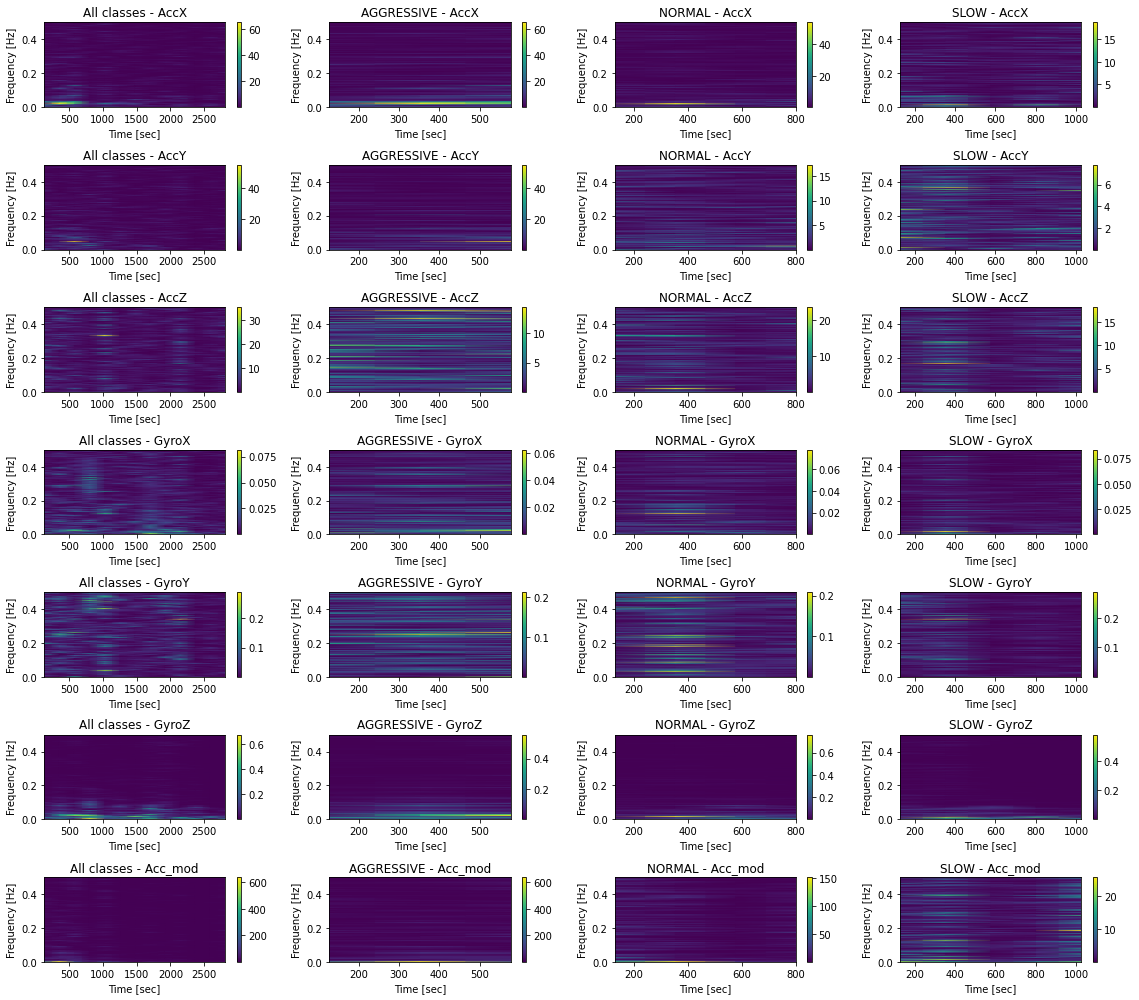

In [29]:
fig,axes=plt.subplots(len(var_columns),4,figsize=(16,2*len(var_columns)))

for ax,column in zip (axes,var_columns):
    data=train_data[column]
    spectogram_analysis(data,ax[0],f'All classes - {column}')
    grouped=train_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=group[column]
        spectogram_analysis(data,ax[groupd_index+1],prefix=f'{key} - {column}')
plt.tight_layout()

#### Test data - The previus analysys was replicated

In [30]:
test_data=pd.read_csv(test_path)
test_data.head(1)

AccX  AccY  AccZ     GyroX     GyroY     GyroZ   Class  Timestamp
0   0.0   0.0   0.0  0.059407 -0.174707  0.101938  NORMAL    3581629

In [31]:
test_data.describe()

AccX         AccY         AccZ        GyroX        GyroY  \
count  3644.000000  3644.000000  3644.000000  3644.000000  3644.000000   
mean      0.040467    -0.073418     0.008271     0.001593    -0.001273   
std       0.985653     0.903408     0.985061     0.066918     0.126205   
min      -4.636523    -4.699795    -7.143998    -0.751822    -1.587028   
25%      -0.550695    -0.592540    -0.558464    -0.028558    -0.053756   
50%       0.003931    -0.080833     0.002262     0.001985    -0.001833   
75%       0.595987     0.452401     0.556157     0.031918     0.051313   
max       4.985548     4.245151     5.171739     0.849255     1.679879   

             GyroZ     Timestamp  
count  3644.000000  3.644000e+03  
mean      0.007949  3.582707e+06  
std       0.115687  6.421479e+02  
min      -1.236468  3.581629e+06  
25%      -0.029398  3.582121e+06  
50%       0.002978  3.582702e+06  
75%       0.040852  3.583270e+06  
max       1.190500  3.583791e+06

In [32]:
test_data.isna().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [33]:
test_data=test_data.sort_values(by='Timestamp')

In [34]:
test_data.Timestamp.unique().shape

(1968,)

There are roughly 2 measurements per second

In [35]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3644 entries, 0 to 3643
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3644 non-null   float64
 1   AccY       3644 non-null   float64
 2   AccZ       3644 non-null   float64
 3   GyroX      3644 non-null   float64
 4   GyroY      3644 non-null   float64
 5   GyroZ      3644 non-null   float64
 6   Class      3644 non-null   object 
 7   Timestamp  3644 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 256.2+ KB


In [36]:
test_data.Timestamp.value_counts().describe()

count    1968.000000
mean        1.851626
std         0.355561
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Timestamp, dtype: float64

It proves that there is not a single timestamp that is replicated many times.

In [37]:
test_data.columns

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')

In [38]:
test_data['Timestamp']=test_data['Timestamp'].astype('int')

test_data['Class']=test_data['Class'].astype('category')
test_data['class_code']=test_data['Class'].cat.codes

In [39]:
var_columns=['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']
label_columns=['class_code','Class']

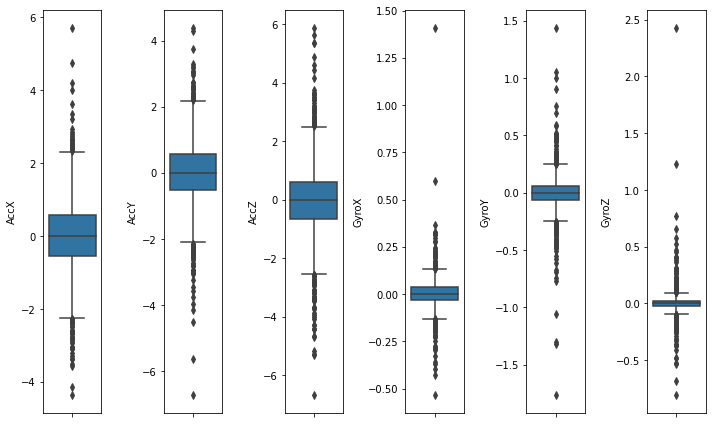

In [40]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

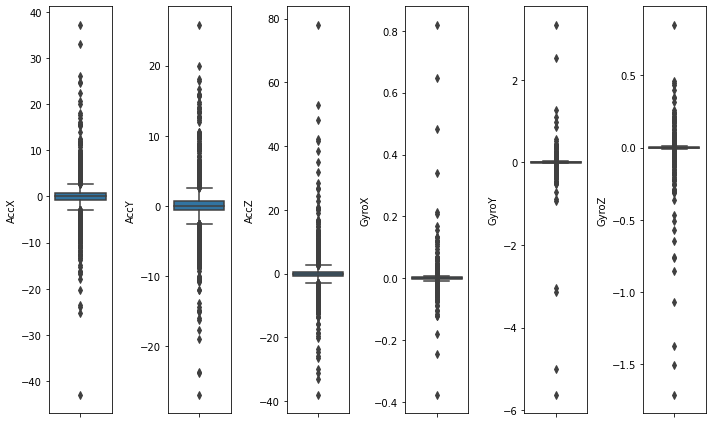

In [41]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

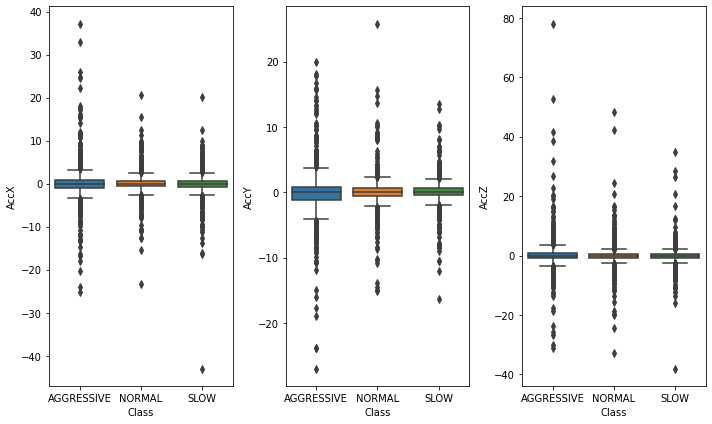

In [42]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
diff=diff.reset_index().merge(test_data.drop_duplicates('Timestamp')[['Timestamp','Class']],right_on='Timestamp',left_on='index')
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(1,len(used_columns),figsize=(10,6))
for column,ax in zip(used_columns,axes.flatten()):
    sns.boxplot(data=diff,y=column,ax=ax,x='Class')
plt.tight_layout()

level of agreeament

[1]Bland, J. Martin, and DouglasG Altman. "Statistical methods for assessing agreement between two methods of clinical measurement." The lancet 327.8476 (1986): 307-310.


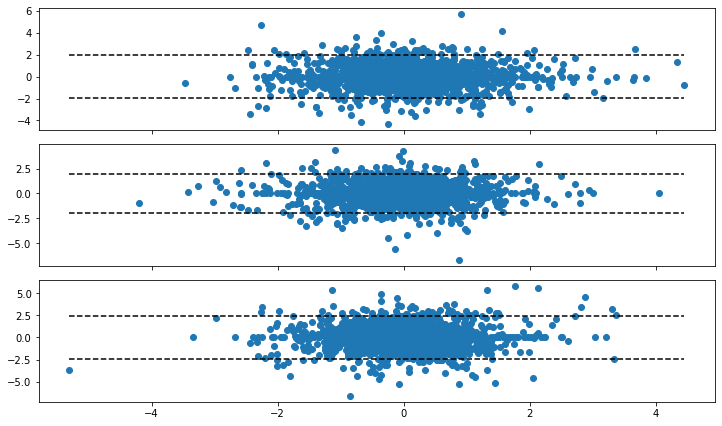

In [43]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(measument1+measument2)*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])
    ax.hlines(np.mean(diff[column])+2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
    ax.hlines(np.mean(diff[column])-2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
plt.tight_layout()


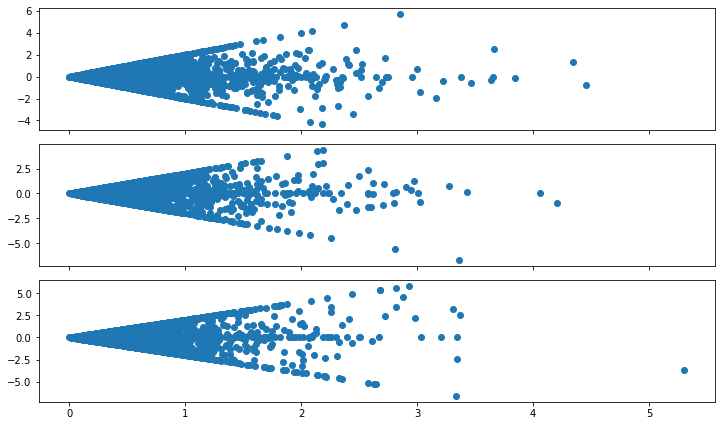

In [44]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(np.abs(measument1)+np.abs(measument2))*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])

plt.tight_layout()


Adding new features.

In [45]:
test_data['Acc_mod']=0.5*(test_data['AccX']**2+test_data['AccY']**2+test_data['AccZ']**2)
var_columns.append('Acc_mod')

Dataset balance

<AxesSubplot:>

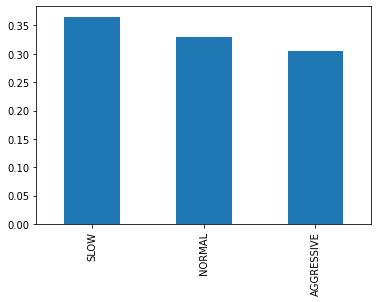

In [46]:
test_data['Class'].value_counts(normalize=True).plot(kind='bar')

Data aumentation

In [47]:
missing_seconds=set(test_data['Timestamp'].unique()).difference(set(range(test_data['Timestamp'].min(),test_data['Timestamp'].max()+1)))
missing_seconds

set()

With this we ensure the signal continuity

Observing the data as a signal

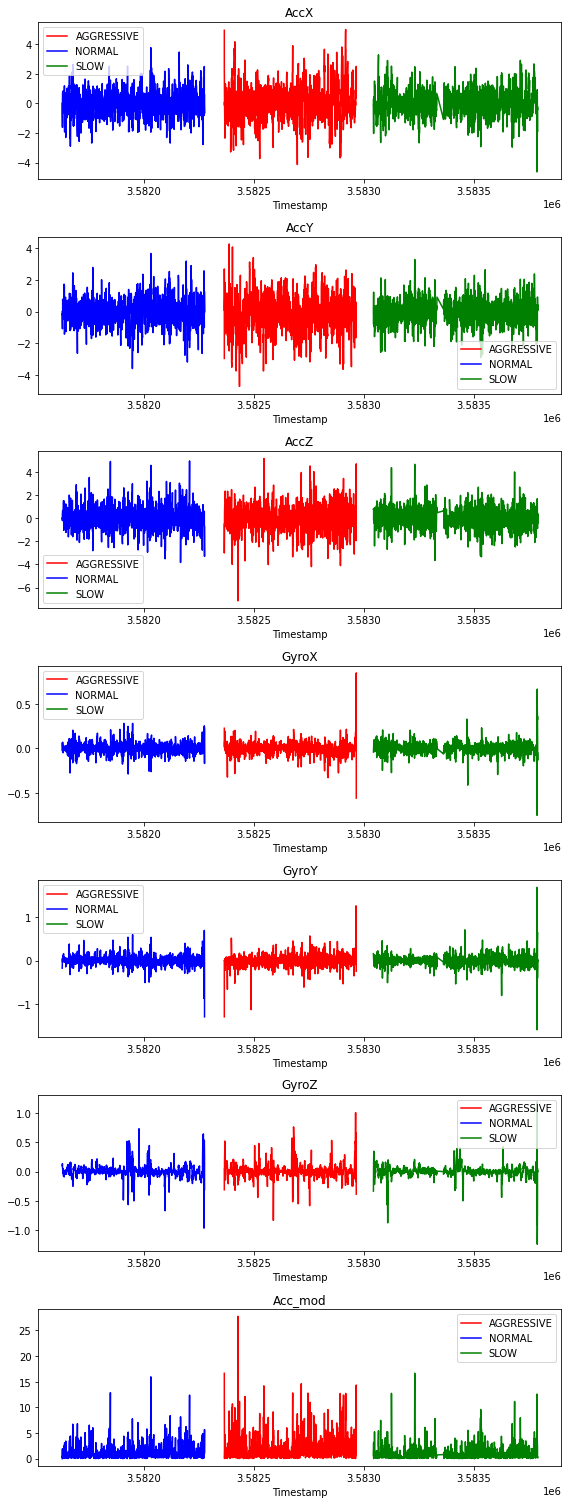

In [48]:
fig,axes=plt.subplots(len(var_columns),1,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes.flatten(),var_columns):
    grouped=test_data.groupby('Class')
    color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
    for key,group in grouped:
        group.plot(ax=ax,x='Timestamp',y=column,label=key,color=color[key])
    ax.set_title(column)
plt.tight_layout()

FFT

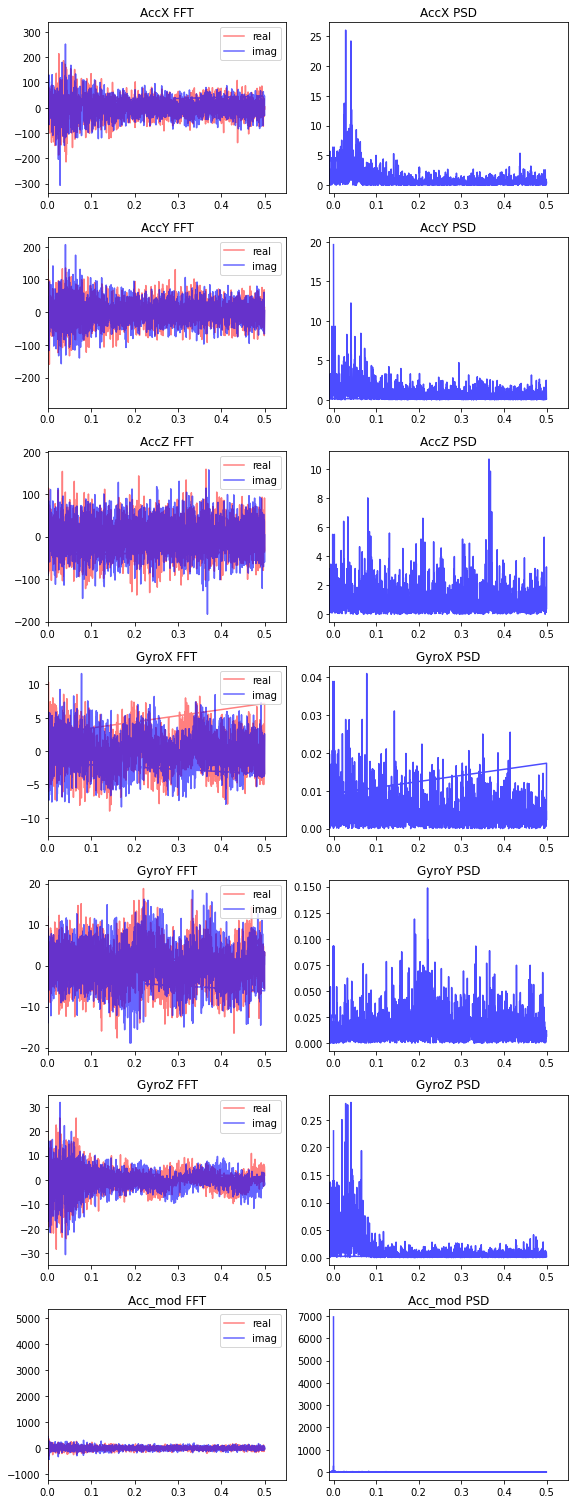

In [49]:
fig,axes=plt.subplots(len(var_columns),2,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    fourier_analysis(test_data[column],ax[0],ax[1],prefix=column)
plt.tight_layout()

Looking the fft of each class, since showed before, there are three continuos periods in data

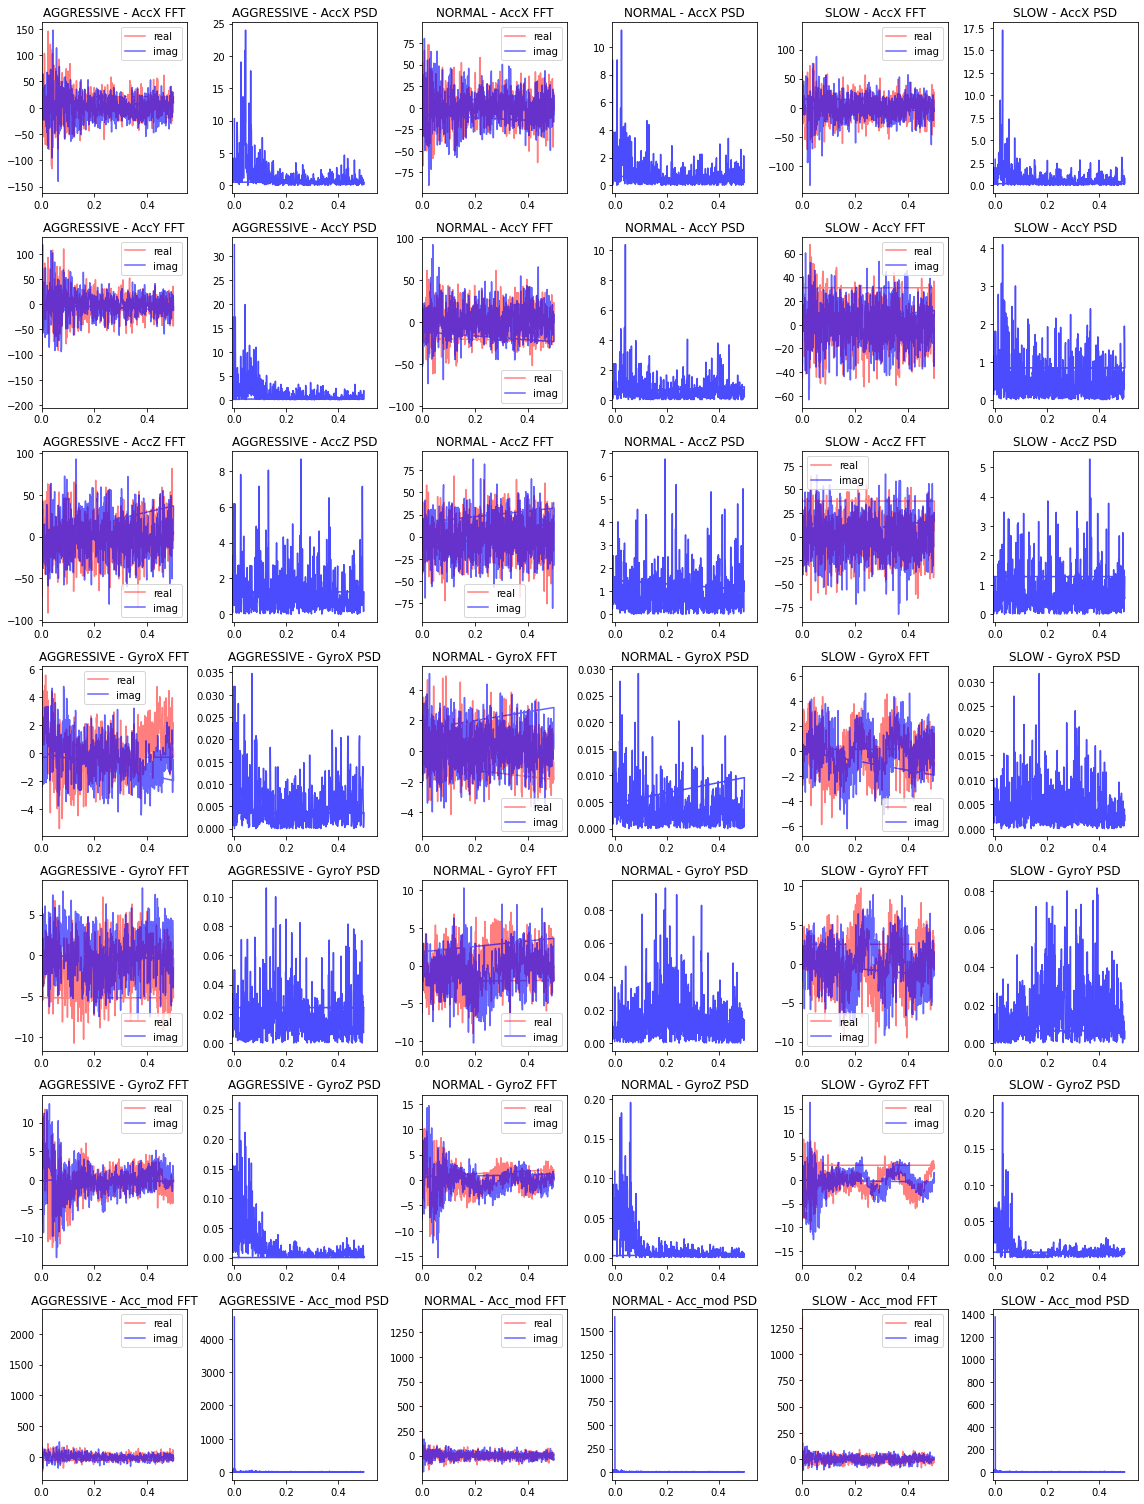

In [50]:
fig,axes=plt.subplots(len(var_columns),6,figsize=(16,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    grouped=test_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=grouped.get_group(key)[column]
        fourier_analysis(data,ax[groupd_index*2],ax[groupd_index*2+1],prefix=f'{key} - {column}')
plt.tight_layout()

spectogram

In [51]:
def spectogram_analysis(data,ax,prefix=''):
    f, t, Sxx = signal.spectrogram(data, 1)
    im=ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(prefix)
    plt.colorbar(im,ax=ax)

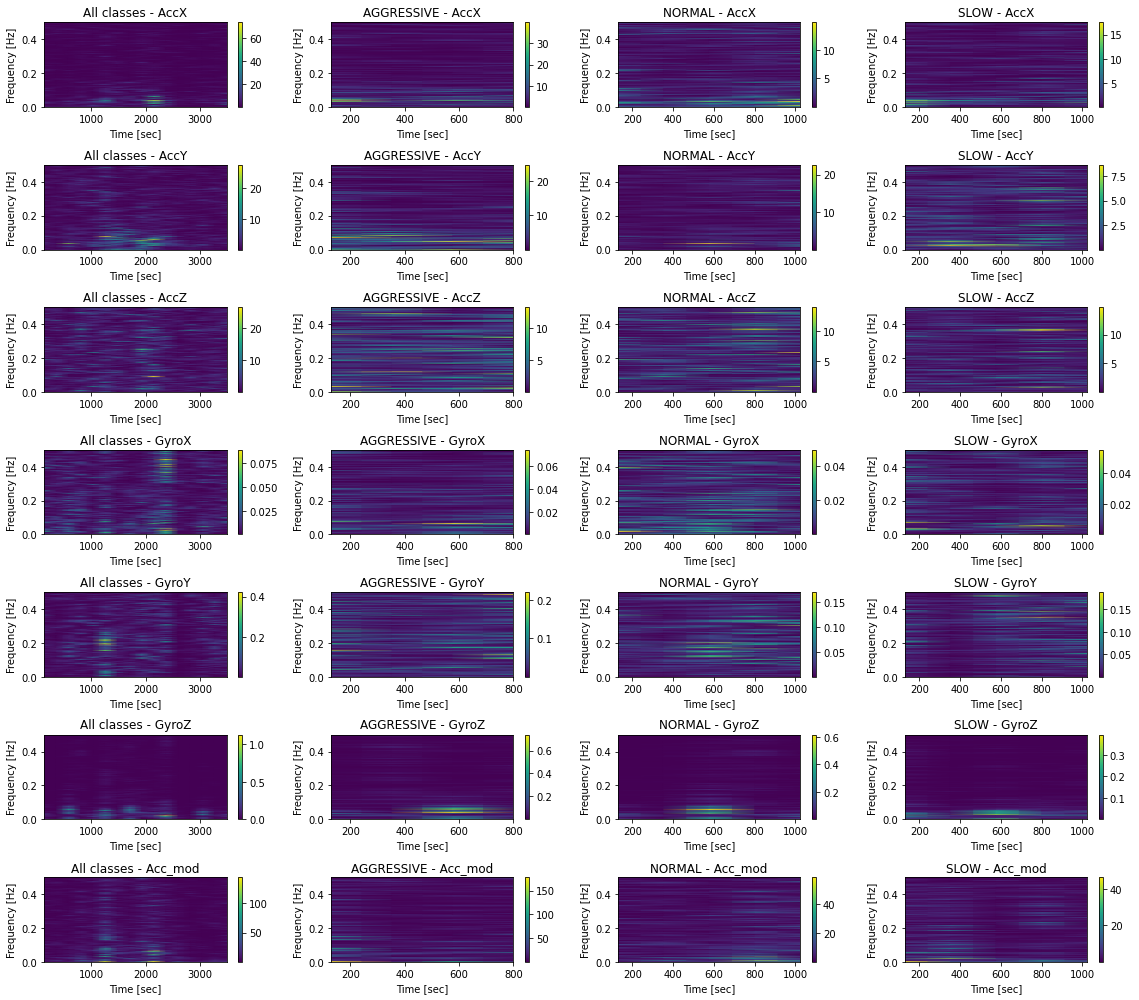

In [52]:
fig,axes=plt.subplots(len(var_columns),4,figsize=(16,2*len(var_columns)))

for ax,column in zip (axes,var_columns):
    data=test_data[column]
    spectogram_analysis(data,ax[0],f'All classes - {column}')
    grouped=test_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=group[column]
        spectogram_analysis(data,ax[groupd_index+1],prefix=f'{key} - {column}')
plt.tight_layout()

### Data processing to aplly AI

Denoising data

In [53]:

def split_numeric_categoric_data(df):

    return df[var_columns],df[label_columns]


def rooling_average(df:pd.DataFrame,window):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.rolling(window).mean()    
    return pd.concat([df_smoothed,df_labels],axis=1)

def exponential_smoothing(df:pd.DataFrame,alpha):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.ewm(alpha=alpha).mean()
    return pd.concat([df_smoothed,df_labels],axis=1)
   
def gaussian_smoothing(df:pd.DataFrame,window,std):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.rolling(window,win_type='gaussian',center=True).mean(std=std)
    return pd.concat([df_smoothed,df_labels],axis=1)

Display of each smoothing method

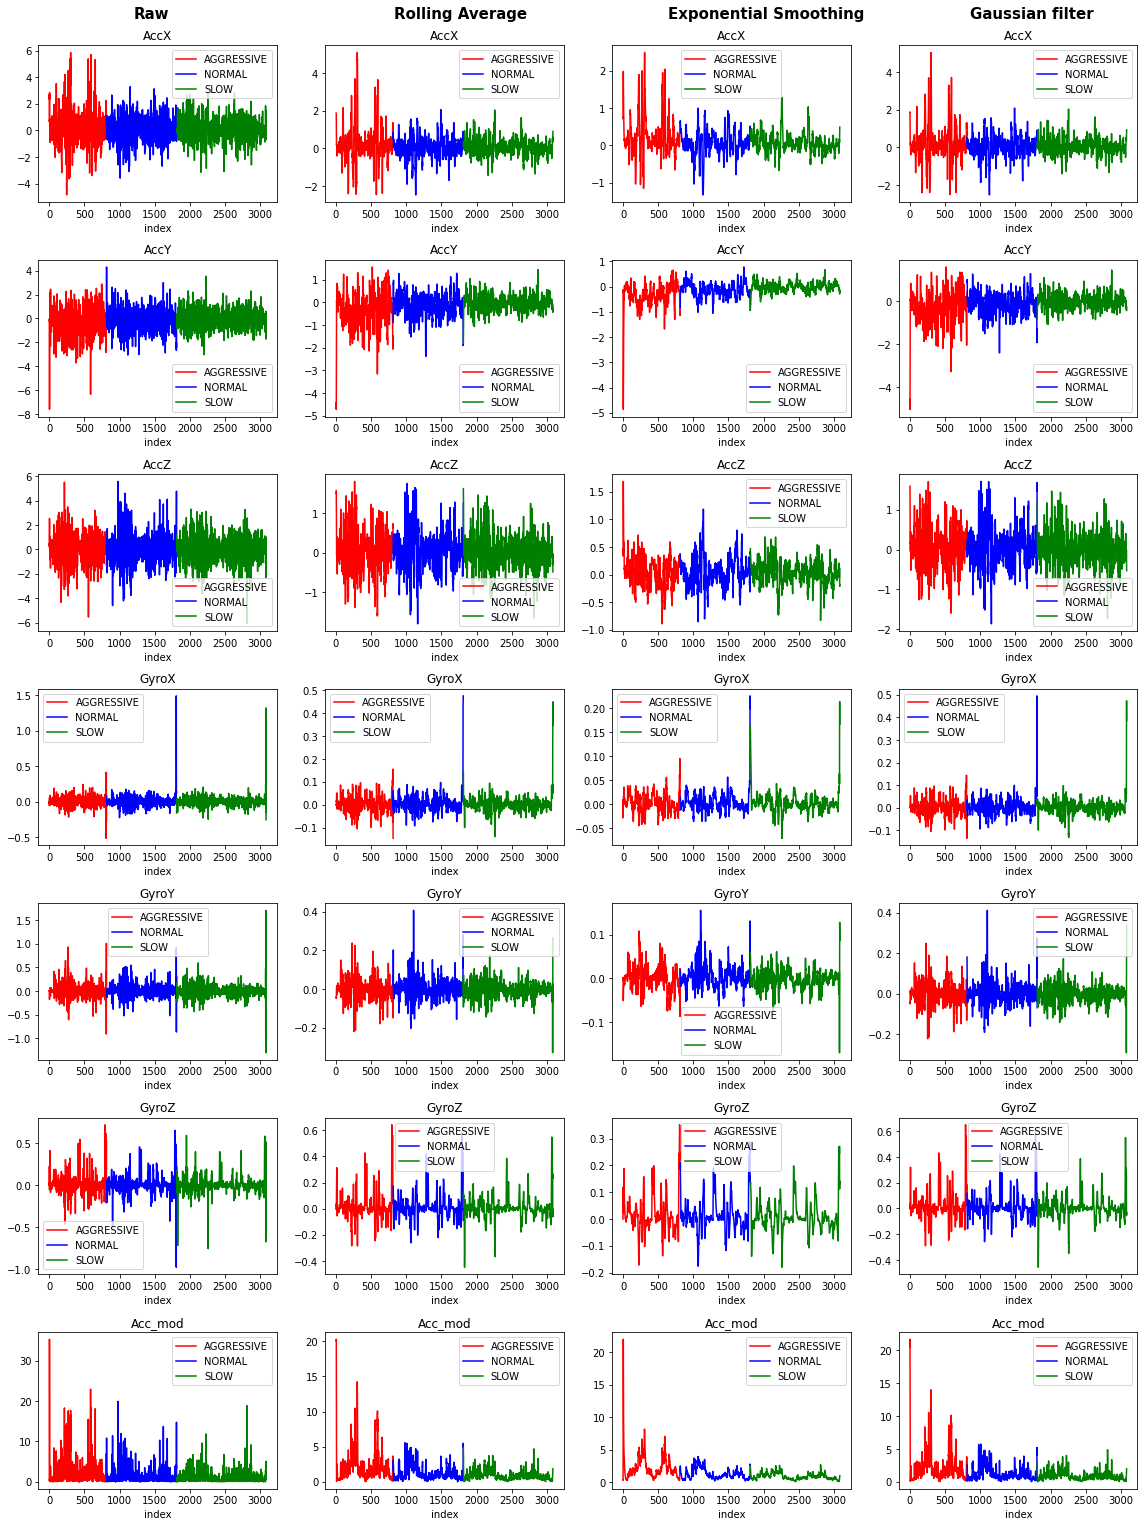

In [54]:
denoised_dfs=[train_data.reset_index()\
              ,rooling_average(train_data,5).reset_index()\
              ,exponential_smoothing(train_data,0.1).reset_index()\
              ,gaussian_smoothing(train_data,5,3).reset_index()\
]
denoise_methods_label=['Raw','Rolling Average','Exponential Smoothing','Gaussian filter']

fig,axes=plt.subplots(len(var_columns),4,figsize=(16,3*len(var_columns)))

for df,(index,label) in zip(denoised_dfs,enumerate(denoise_methods_label)):
    for ax,column in zip (axes[:,index].flatten(),var_columns):
        grouped=df.groupby('Class')
        color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
        for key,group in grouped:
            group.plot(ax=ax,x='index',y=column,label=key,color=color[key])
        ax.set_title(column)
    fig.text(.125-0.002*len(label)+0.25*index,1,label,fontsize=15,weight='bold')
plt.tight_layout()

The models that will be built aims to find which data are related to agressive driving, then, it will became a binary classification problem.

The input data should be a sequence of seconds, since the acceleration of a given seconds does not provide enough information about the driving beahaviour

Data loader

In [55]:
@dataclass
class DataLoader:
    train_df:pd.DataFrame
    test_df:pd.DataFrame
    var_columns:list
    class_column:list
    seed=123    

    def smoothing(self,method='rolling_average',*args,**kwargs):        
        """
        method: either 'gaussian','exponential','rolling_average'
        """
        
        if method=='exponential':
            func=DataLoader.__exponential_smoothing
        elif method=='gaussian':
            func=DataLoader.__gaussian_smoothing
        else:
            func=DataLoader.__rooling_average
        
        self.train_df=self.__apply_smoothing(self.train_df,func,args,kwargs)
        self.test_df=self.__apply_smoothing(self.test_df,func,args,kwargs)
    
    def __apply_smoothing(self,df,func,func_args,func_kwargs):
        df_numeric,df_labels=df[self.var_columns],df[self.class_column]
        df_numeric=func(df_numeric,*func_args,**func_kwargs)
        return pd.concat([df_numeric,df_labels],axis=1).dropna()
    
    @staticmethod
    def __rooling_average(df:pd.DataFrame,window):
        df_smoothed=df.rolling(window).mean()
        return df_smoothed

    @staticmethod
    def __exponential_smoothing(df:pd.DataFrame,alpha):
        df_smoothed=df.ewm(alpha=alpha).mean()
        return df_smoothed
    
    @staticmethod
    def __gaussian_smoothing(df:pd.DataFrame,window,std):
        df_smoothed=df.rolling(window,win_type='gaussian',center=True).mean(std=std)
        return df_smoothed

    def __get_val_data(self):  
        np.random.seed(self.seed)                 
        X,Y=self.test_df[self.var_columns].values,self.test_df[self.class_column].values
        self.Xtest,self.Xval,self.Ytest,self.Yval=train_test_split(X,Y,test_size=.5,stratify=Y)     

    def __get_val_data_sequence(self):   
        np.random.seed(self.seed)        
        X,Y=self.XtestSequence,self.YtestSequence
        self.XtestSequence,self.XvalSequence,self.YtestSequence,self.YvalSequence=train_test_split(X,Y,test_size=.5,stratify=Y)     
    
    def __create_sequences(self,df,sequence_size):
        X=[]
        Y=[]
        for key in df[self.class_column[0]].unique():
            train_class=df[df[self.class_column[0]]==key]  
            for row_shift in range(sequence_size):
                size=(len(train_class)-row_shift)//sequence_size*sequence_size
                X_temp=train_class[var_columns].values[row_shift:size+row_shift]\
                                                .reshape(-1,len(var_columns),sequence_size)
                Y_temp=np.array([key]*len(X_temp)).reshape(-1,1)
                if len(X)!=0:
                    X=np.vstack((X,X_temp))
                    Y=np.vstack((Y,Y_temp))
                else:
                    X=X_temp
                    Y=Y_temp
        return X,Y

    def get_train_val_test_arrays(self):
        self.Xtrain=self.train_df[self.var_columns].values
        self.Ytrain=self.train_df[self.class_column].values
        self.__get_val_data()
        return self.Xtrain,self.Ytrain,self.Xval,self.Yval,self.Xtest,self.Ytest
    
    def get_train_val_test_sequence(self):
        self.__get_val_data_sequence()
        return self.XtrainSequence,self.YtrainSequence,self.XvalSequence,self.YvalSequence,self.XtestSequence,self.YtestSequence
    
    def to_sequecence(self,sequence_size):
        self.XtrainSequence,self.YtrainSequence=self.__create_sequences(self.train_df,sequence_size)
        self.XtestSequence,self.YtestSequence=self.__create_sequences(self.test_df,sequence_size)
        

    
    def to_binary_classes(self,map):
        self.train_df[self.class_column[0]]=self.train_df[self.class_column[0]].map(map)
        self.test_df[self.class_column[0]]=self.test_df[self.class_column[0]].map(map)
        


In [56]:
dataloader=DataLoader(train_data.copy(),test_data.copy(),var_columns,['class_code'])
map={0:1,2:0,1:0}
dataloader.to_binary_classes(map)
dataloader.smoothing('gaussian',window=5,std=3)
X_train,Y_train,X_val,Y_val,X_test,Y_test=dataloader.get_train_val_test_arrays()


In [57]:
train_data[label_columns].value_counts()


class_code  Class     
2           SLOW          1273
1           NORMAL         997
0           AGGRESSIVE     814
dtype: int64

In [58]:
np.unique(Y_train,return_counts=True)

(array([0, 1], dtype=int64), array([2268,  812], dtype=int64))

In [59]:
test_data[label_columns].value_counts()


class_code  Class     
2           SLOW          1331
1           NORMAL        1200
0           AGGRESSIVE    1113
dtype: int64

In [60]:
print(np.unique(Y_val,return_counts=True),np.unique(Y_test,return_counts=True))

(array([0, 1], dtype=int64), array([1264,  556], dtype=int64)) (array([0, 1], dtype=int64), array([1263,  557], dtype=int64))


In [61]:
dataloader.to_sequecence(3)
X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence=dataloader.get_train_val_test_sequence()

In [62]:
X_trainSequence.shape,Y_trainSequence.shape

((3076, 7, 3), (3076, 1))

In [63]:
np.unique(Y_trainSequence,return_counts=True)

(array([0, 1], dtype=int64), array([2266,  810], dtype=int64))

### Models

In [ ]:
class ClassificationModel():
    def __init__(self,model,Xtrain,Ytrain,scaler=False,random_state=123,**kwargs):
        self.random_state=random_state
        if scaler:
            self.model=make_pipeline(StandardScaler(),model(**kwargs))
        else:
            self.model=model(**kwargs)
        self.Xtrain=Xtrain
        self.Ytrain=Ytrain
        self._get_label_proportion(Ytrain,prefix='train')
        
    


    def fit(self,**kwargs): 
        if 'sample_weight_map' in kwargs.keys():
            map=kwargs.pop('sample_weight_map')
            sample_weight=self._get_sample_weight(map)
            kwargs['sample_weight']=sample_weight

        np.random.seed(self.random_state)  
        self.model.fit(self.Xtrain,self.Ytrain,**kwargs)

    def evaluate(self,Xtest,Ytest):
        self._get_label_proportion(Ytest,prefix='test')
        self.pred=self.model.predict(Xtest)
        self._get_accuracy(Ytest)
        self._get_balanced_accuracy(Ytest)
        self._get_confusion_matrix(Ytest)
        self._get_class_report(Ytest)

    

    def _get_confusion_matrix(self,Ytest):
        cm = confusion_matrix(Ytest,self.pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
    
    def _get_class_report(self,Ytest):
        report=classification_report(Ytest,self.pred)
        print(report)

    def _get_accuracy(self,Ytest):
        accuracy=accuracy_score(Ytest,self.pred)
        print(f'The accuracy observed was {accuracy*100:.0f} %')

    def _get_balanced_accuracy(self,Ytest):
        accuracy=balanced_accuracy_score(Ytest,self.pred)
        print(f'The balanced accuracy observed was {accuracy*100:.0f} %')    
    
    def _get_label_proportion(self,Y,prefix=''):
        true_rate=(sum(Y==1)/len(Y))[0]
        print(f'{prefix}: The dataset has {true_rate*100:.0f}% of positive')
    
    def _get_sample_weight(self,map):
        sample_weights=class_weight.compute_sample_weight(map,self.Ytrain)
        return sample_weights

### Machine learning

Logistic Regression

In [ ]:
LR=ClassificationModel(LogisticRegression,X_train,Y_train,n_jobs=-1)
LR.fit()
LR.evaluate(X_val,Y_val)

Logistic regression with Scaled data

In [ ]:
LR=ClassificationModel(LogisticRegression,X_train,Y_train,scaler=True)
LR.fit()
LR.evaluate(X_val,Y_val)

SVM

In [ ]:
SVC_model=ClassificationModel(SVC,X_train,Y_train,scaler=True,class_weight={0:1,1:3})
SVC_model.fit()
SVC_model.evaluate(X_val,Y_val)

Random Forest

In [ ]:
RF=ClassificationModel(RandomForestClassifier,X_train,Y_train,n_jobs=-1,class_weight={0:1,1:3})
RF.fit()
RF.evaluate(X_val,Y_val)

Naive Bayes

In [ ]:
MB=ClassificationModel(GaussianNB,X_train,Y_train,priors=[.3,0.7])
MB.fit()
MB.evaluate(X_val,Y_val)

Xgboost

In [ ]:
XGB=ClassificationModel(XGBClassifier,X_train,Y_train)
XGB.fit(sample_weight_map={0:1,1:3})
XGB.evaluate(X_val,Y_val)

### Deep Learning

In [227]:

from abc import abstractclassmethod
class DLModel():

    def __init__(self,Xtrain,Ytrain,Xval,Yval,Xtest,Ytest):
        self.Xtrain=Xtrain
        self.Ytrain=Ytrain
        self.Xval=Xval
        self.Yval=Yval
        self.Xtest=Xtest
        self.Ytest=Ytest
        self.training_history=[]
        self.model=self.model_compiler()
    
    @property
    def architecture(self):
        return self.model.summary()
    
    @abstractclassmethod
    def model_compiler(self):
        pass

    @abstractclassmethod
    def training_params(self)->dict:
        pass   

    def train(self,seed=123,verbose=0):
        np.random.seed(seed)
        history=self.model.fit(self.Xtrain,self.Ytrain,validation_data=(self.Xval,self.Yval),verbose=verbose,**self.training_params())
        self.training_history.append(history)     

    def test(self):
        threshold=0.5
        self.predictions=self.model.predict(self.Xtest)
        self.binary_predictions=(self.predictions>threshold).astype(int)
        test_accuracy=accuracy_score(self.Ytest,self.binary_predictions)        
        test_balanced_accuracy=balanced_accuracy_score(self.Ytest,self.binary_predictions)        

        test_precision=precision_score(self.Ytest,self.binary_predictions)
        test_recall=recall_score(self.Ytest,self.binary_predictions)
        auc=roc_auc_score(self.Ytest,self.binary_predictions)
        print(f'Test accuracy : {test_accuracy*100:.0f} %')
        print(f'Test balanced accuracy : {test_balanced_accuracy*100:.0f} %')

        print(f'Test precision : {test_precision*100:.0f} %')
        print(f'Test recall : {test_recall*100:.0f} %')
        print(f'Model AUC : {auc*100:.0f} %')
        self.confusion_matrix_plot()
    
    def test_metrics(self):
        threshold=0.5
        self.predictions=self.model.predict(self.Xtest)
        self.binary_predictions=(self.predictions>threshold).astype(int)
        test_accuracy=accuracy_score(self.Ytest,self.binary_predictions)        
        test_balanced_accuracy=balanced_accuracy_score(self.Ytest,self.binary_predictions)        

        test_precision=precision_score(self.Ytest,self.binary_predictions)
        test_recall=recall_score(self.Ytest,self.binary_predictions)
        auc=roc_auc_score(self.Ytest,self.binary_predictions)
        return {"AUC":auc,
                    "test_recall":test_recall,
                    "test_precision":test_precision,
                    "test_balanced_accuracy":test_balanced_accuracy,
                    "test_accuracy":test_accuracy}
    
    
    def _store_models_hyperparams(self,**kwargs):
        self.model_hyperparams=kwargs

    @staticmethod
    def __unpack_data_history(history_record,key):
        key=DLModel.__get_metric_key_by_prefix(key,history_record)
        metric=[]
        for train_data in history_record:
            metric.extend(train_data.history[key])
        
        return metric
    
    @staticmethod
    def __get_metric_key_by_prefix(key,history_record):
        key_in_history=''
        if 'val' in key:
            for metric in history_record[-1].history.keys():
                if key in metric:
                    key_in_history=metric
                    break
        else:
            for metric in history_record[-1].history.keys():
                if key in metric and 'val' not in metric:
                    key_in_history=metric
                    break

        return key_in_history

    def loss_plot(self,ax=None):
        if not ax:
            loss=DLModel.__unpack_data_history(self.training_history,'loss')
            loss_val=DLModel.__unpack_data_history(self.training_history,'val_loss')

            plt.title('loss')
            plt.plot(loss,label='train')
            plt.plot(loss_val,label='val')

            plt.xlabel('epochs')
            plt.show()
        else:
            pass

    def accuracy_plot(self,ax=None):
        if not ax:        
            accuracy=DLModel.__unpack_data_history(self.training_history,'binary_accuracy')
            val_accuracy=DLModel.__unpack_data_history(self.training_history,'val_binary_accuracy')
            plt.title('Accuracy')
            plt.plot(accuracy,label='train')
            plt.plot(val_accuracy,label='val')
            plt.legend()
            plt.xlabel('epochs')
            plt.grid(True)
            plt.show()
        else:
            pass


    def precision_recall_plot(self,ax=None):
        if not ax:
            precision=DLModel.__unpack_data_history(self.training_history,'precision')
            recall=DLModel.__unpack_data_history(self.training_history,'recall')
            val_precision=DLModel.__unpack_data_history(self.training_history,'val_precision')
            val_recall=DLModel.__unpack_data_history(self.training_history,'val_recall')
            plt.subplot(1,2,1)
            plt.title('Precision')
            plt.plot(precision,label='Train')
            plt.plot(val_precision,label='Val') 
            plt.xlabel('epochs')
            plt.legend()
            plt.subplot(1,2,2)
            plt.title('Recall')
            plt.plot(recall,label='Train')
            plt.plot(val_recall,label='Val') 
            plt.xlabel('epochs')
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            pass
    
    
    def confusion_matrix_plot(self):
        if hasattr(self, 'predictions'):
            cm = confusion_matrix(self.Ytest,self.binary_predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
        else:
            print('Test method should be called before')

    def plot_all_training_metrics(self):
        self.loss_plot()
        self.accuracy_plot()
        self.precision_recall_plot()

    def multiple_seeds_analysis(self,seeds:list):
        pass
    

    


#### MLP

model 1

In [ ]:
class model_1(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)

    def model_compiler(self):
        MLP_model=keras.Sequential(
                [
                
                    keras.Input(shape=(7,)),
                    keras.layers.Dense(10,activation='tanh', kernel_initializer="glorot_uniform"),
                    keras.layers.Dense(10,activation='tanh'),
                    keras.layers.Dropout(0.4),    
                    keras.layers.Dense(6,activation='tanh'),
                    keras.layers.Dense(6,activation='tanh'),
                    keras.layers.Dense(1,activation='sigmoid')
                ]
                )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
          
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}


    

In [ ]:
model=model_1(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

Running with a different seed

In [ ]:
model=model_1(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.train(seed=321)
# model.plot_all_training_metrics()
model.test()

model 2

In [ ]:
class model_2(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(10,activation='tanh', kernel_initializer="glorot_uniform"),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(10,activation='tanh'),
                keras.layers.Dropout(0.4),    
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dropout(0.7),  
                keras.layers.Dense(10,activation='tanh'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}



In [ ]:
model=model_2(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

In [ ]:
model=model_2(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.train(seed=123)
model.test()

model 3

In [ ]:
class model_3(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5,activation='tanh'),
                keras.layers.Dropout(0.4),    
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dropout(0.7),  
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(4,activation='tanh'),
                keras.layers.Dense(2,activation='tanh'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)

        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}



In [ ]:
model=model_3(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

In [ ]:
model=model_3(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.train(seed=123)
model.test()

model 4

In [ ]:
class model_4(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(5,activation='selu', kernel_initializer="glorot_uniform"),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5,activation='selu'),
                keras.layers.Dropout(0.4),    
                keras.layers.Dense(3,activation='selu'),
                keras.layers.Dense(3,activation='selu'),
                keras.layers.Dropout(0.7),  
                keras.layers.Dense(6,activation='selu'),
                keras.layers.Dense(4,activation='selu'),
                keras.layers.Dense(2,activation='selu'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)

        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}



In [ ]:
model=model_4(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

model 5

In [ ]:
class model_5(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5,activation='tanh'),
                keras.layers.Dropout(0.4),    
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dropout(0.7),  
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(4,activation='tanh'),
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(4,activation='tanh'),
                keras.layers.Dense(6,activation='tanh'),
                keras.layers.Dense(4,activation='tanh'),
                keras.layers.Dense(2,activation='tanh'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)

        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}



In [ ]:
model=model_5(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

model 6

In [ ]:
class model_6(DLModel):
    def __init__(self,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        
    def model_compiler(self):        
        MLP_model=keras.Sequential(
            [
                keras.Input(shape=(7,)),            
                keras.layers.Dense(5,activation='tanh', kernel_initializer="glorot_uniform"),
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dense(3,activation='tanh'),
                keras.layers.Dense(1,activation='sigmoid')
            ]
            )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)

        return MLP_model
    
    def training_params(self):
        epochs=300
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)       
        
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}



In [ ]:
model=model_6(X_train,Y_train,X_val,Y_val,X_test,Y_test)
model.architecture
model.train(seed=123)
model.plot_all_training_metrics()
model.test()

#### CNN

##### Recurrente Plot Aproach

Spiegel, S., Jain, J.-B., & Albayrak, S. (2014). A recurrence plot-based distance measure.

In [ ]:
@dataclass
class RecurrenceImageLoader(DataLoader):

    
    def ordenate_data(self,columns_order:list,images_depth:list):
        self.train_df=self.train_df[columns_order]
        self.test_df=self.test_df[columns_order]
        self.images_depth=images_depth
    

    def recurrence_plot_params(self,**kwargs):
        self.RecurrencePloter=RecurrencePlot(**kwargs)


    def generate_recurrence_plots(self):
        self.XtrainRPImgs=self.__recurrence_plots(self.XtrainSequence)
        self.XvalRPImgs=self.__recurrence_plots(self.XvalSequence)
        self.XtestRPImgs=self.__recurrence_plots(self.XtestSequence)
    
    def __recurrence_plots(self,Tensor)-> np.array:
        X_img_channels=[]
        for Matrix in Tensor:
                img_channels_temp=[]    
                for Vec in Matrix:
                  img_channels_temp.append(np.squeeze(self.RecurrencePloter.transform(Vec.reshape(-1,len(Vec))),axis=0))
                X_img_channels.append(img_channels_temp)

        return np.swapaxes(np.array(X_img_channels),1,-1)
    
    
    def customize_recurrance_plots(self):
        self.XtrainRPImgs=self.__customize_recurrence_plot(self.XtrainRPImgs)
        self.XvalRPImgs=self.__customize_recurrence_plot(self.XvalRPImgs)
        self.XtestRPImgs=self.__customize_recurrence_plot(self.XtestRPImgs)

    def __customize_recurrence_plot(self,imgs):      
        if hasattr(self,'images_depth'):
            depths=self.images_depth
        else:
            raise Exception("The method ordenate_data should be called before")
        new_imgs=[]
        for img in imgs:
            channels=0
            new_img_temp=[]
            for depth in depths:     
                new_img_temp.append(self.concat_channels(*np.swapaxes(img[:,:,range(channels,channels+depth)],-1,0)))
                channels+=depth
            new_imgs.append(self.concat_imgs(*new_img_temp))

        return np.array(new_imgs)


    def expand_image_size(self,new_shape):
        """ new_shape is a iterable in each the first item sets how height will be expanded and the second item will sets the width expansion """
        self.XtrainRPImgs=self._expand_image_by_replicating(self.XtrainRPImgs,new_shape)
        self.XvalRPImgs=self._expand_image_by_replicating(self.XvalRPImgs,new_shape)
        self.XtestRPImgs=self._expand_image_by_replicating(self.XtestRPImgs,new_shape)
        return self.XtrainRPImgs,self.XvalRPImgs,self.XtestRPImgs

    @staticmethod
    def _expand_image_by_replicating(tensor,new_shape:list)->np.array:
        """ 
            For each channel replicates n times some line, and m times some collumn in order to expand them 
        """
        new_tensor_shape=np.ones(4)
        new_tensor_shape[1:3]=new_shape
        new_tensor=np.zeros(shape=np.multiply(tensor.shape,new_tensor_shape).astype(int))
        for index,matrix in enumerate(tensor):
            new_tensor[index]=np.repeat(matrix,new_shape[0],axis=0).repeat(new_shape[1],axis=1)
            
        return new_tensor



    @staticmethod
    def concat_channels(*args):
        rgb_img=np.stack((args),axis=-1)
        return rgb_img
    
    @staticmethod
    def concat_imgs(*args):
        concated_rgb_img=np.vstack((args))
        return concated_rgb_img
    
    def get_train_val_test_recurrence_img(self):
        if not hasattr(self,'XvalSequence'):
            self.get_train_val_test_sequence()
        self.generate_recurrence_plots()
        return self.XtrainRPImgs,self.YtrainSequence,self.XvalRPImgs,self.YvalSequence,self.XtestRPImgs,self.YtestSequence

    def get_train_val_test_recurrence_img_customized(self):
        if not hasattr(self,'XvalSequence'):
            self.get_train_val_test_sequence()
        self.generate_recurrence_plots()
        self.customize_recurrance_plots()
        return self.XtrainRPImgs,self.YtrainSequence,self.XvalRPImgs,self.YvalSequence,self.XtestRPImgs,self.YtestSequence



        
                    
                    

In [ ]:
dataloader=RecurrenceImageLoader(train_data.copy(),test_data.copy(),var_columns,['class_code'])
map={0:1,2:0,1:0}
dataloader.to_binary_classes(map)
dataloader.smoothing('gaussian',window=5,std=3)
dataloader.to_sequecence(10)
dataloader.recurrence_plot_params(threshold=0.5)
columns_order=['GyroX', 'GyroY', 'GyroZ','AccX', 'AccY', 'AccZ']
depths=[3,3]
dataloader.ordenate_data(columns_order,depths)
X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img=dataloader.get_train_val_test_recurrence_img_customized()
X_train_img.shape,Y_train_img.shape


In [ ]:
sample=PIL.Image.fromarray(X_train_img[0],mode="RGB")
plt.imshow(sample)

##### Using 2 convolutional layers

Model 1

In [ ]:
class modelCNN_1(DLModel):
    def __init__(self,*args,**kwargs) -> None:        
        self.r=0.25
        self.n=16
        self.m=30
        self.alpha=0.2
        self.filter_size=2
        super().__init__(*args,**kwargs)

    def set_cnn_params(self,r=0.25,n=16,m=30,alpha=0.2,filter_size=2):
        self.r=r
        self.n=n
        self.m=m
        self.alpha=alpha
        self.filter_size=filter_size
        self.model=self.model_compiler()

    def model_compiler(self):
       

        MLP_model=keras.Sequential(
                    [
                    keras.Input((20,10,3)),
                    keras.layers.Conv2D(filters=self.n,kernel_size=self.filter_size, kernel_initializer="glorot_uniform"),
                    keras.layers.LeakyReLU(self.alpha),
                    keras.layers.Conv2D(filters=2*self.n,kernel_size=self.filter_size),
                    keras.layers.LeakyReLU(self.alpha),
                    keras.layers.MaxPooling2D(),
                    keras.layers.Dropout(self.r),          
                    keras.layers.GlobalMaxPool2D(),
                    keras.layers.Dense(self.m,activation='relu'),
                    keras.layers.Dense(1,activation='sigmoid') 
                    ]
                    )
        # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1.,decay_steps=10000,decay_rate=0.95)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adadelta(learning_rate=1.,rho=0.95)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=15
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}


    


In [ ]:
cnn_model=modelCNN_1(X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img)
cnn_model.set_cnn_params()
cnn_model.architecture
cnn_model.train(seed=123)
cnn_model.plot_all_training_metrics()
cnn_model.test()

Testing filter_size=5

In [ ]:
cnn_model=modelCNN_1(X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img)
cnn_model.set_cnn_params(filter_size=5,n=32)
cnn_model.architecture
cnn_model.train(seed=123)
cnn_model.train(seed=123)
cnn_model.plot_all_training_metrics()
cnn_model.test()

Testing filter size=5 and 32 filters in the first convolutional layer

In [ ]:
cnn_model=modelCNN_1(X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img)
cnn_model.set_cnn_params(filter_size=5,n=32)
cnn_model.architecture
cnn_model.train(seed=123)
cnn_model.train(seed=123)
cnn_model.plot_all_training_metrics()
cnn_model.test()

##### Using 3 convolutional layers

In [ ]:
class modelCNN_2(DLModel):
    def __init__(self,*args,**kwargs) -> None:        
        self.r=0.25
        self.n=16
        self.m=30
        self.alpha=0.2
        self.filter_size=2
        super().__init__(*args,**kwargs)

    def set_cnn_params(self,r=0.25,n=16,m=30,alpha=0.2,filter_size=2):
        self.r=r
        self.n=n
        self.m=m
        self.alpha=alpha
        self.filter_size=filter_size
        self.model=self.model_compiler()

    def model_compiler(self):
       

        MLP_model=keras.Sequential(
                    [
                    keras.Input((20,10,3)),
                    keras.layers.Conv2D(filters=self.n,kernel_size=self.filter_size, kernel_initializer="glorot_uniform"),
                    keras.layers.LeakyReLU(self.alpha),
                    keras.layers.Conv2D(filters=2*self.n,kernel_size=self.filter_size),
                    keras.layers.LeakyReLU(self.alpha),
                    keras.layers.MaxPooling2D(),
                    keras.layers.Dropout(self.r),    
                    keras.layers.Conv2D(filters=2*self.n,kernel_size=self.filter_size-1),
                    keras.layers.LeakyReLU(self.alpha),
                    keras.layers.MaxPooling2D(),
                    keras.layers.Dropout(self.r),      
                    keras.layers.GlobalMaxPool2D(),
                    keras.layers.Dense(self.m,activation='relu'),
                    keras.layers.Dense(1,activation='sigmoid') 
                    ]
                    )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1.,decay_steps=10000,decay_rate=0.95)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=15
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
                
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}


    


In [ ]:
cnn_model=modelCNN_2(X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img)
cnn_model.set_cnn_params(filter_size=3)
cnn_model.architecture
cnn_model.train(seed=123)
cnn_model.train(seed=123)

cnn_model.plot_all_training_metrics()
cnn_model.test()

Testing filter_size=5

In [ ]:
cnn_model=modelCNN_2(X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img)
cnn_model.set_cnn_params(filter_size=2,n=8)
cnn_model.architecture
cnn_model.train(seed=123)


cnn_model.plot_all_training_metrics()
cnn_model.test()

In [ ]:
class modelCNN_3(DLModel):
    def __init__(self,*args,**kwargs) -> None:        
        self.r=0.25
        self.n=16
        self.m=30
        self.alpha=0.2
        self.filter_size=2
        super().__init__(*args,**kwargs)

    def set_cnn_params(self,r=0.25,n=16,m=30,alpha=0.2,filter_size=2):
        self.r=r
        self.n=n
        self.m=m
        self.alpha=alpha
        self.filter_size=filter_size
        self.model=self.model_compiler()

    def model_compiler(self):
       

        MLP_model=keras.Sequential(
                    [
                    keras.Input((20,10,3)),
                    keras.layers.Conv2D(filters=self.n,kernel_size=self.filter_size, kernel_initializer="glorot_uniform",padding='same'),
                    keras.layers.LeakyReLU(self.alpha),
                    keras.layers.Conv2D(filters=2*self.n,kernel_size=self.filter_size,padding='same'),
                    keras.layers.LeakyReLU(self.alpha),
                    keras.layers.MaxPooling2D(padding='same'),
                    keras.layers.Dropout(self.r),          
                    keras.layers.GlobalMaxPool2D(),
                    keras.layers.Dense(self.m,activation='relu'),
                    keras.layers.Dense(1,activation='sigmoid') 
                    ]
                    )
        # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1.,decay_steps=10000,decay_rate=0.95)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adadelta(learning_rate=1.,rho=0.95)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=15
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
                
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}


    


Testing filter_size=5 and 32 filters in the first convolutional layer

In [ ]:
cnn_model=modelCNN_3(X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img)
cnn_model.set_cnn_params(filter_size=7,n=16)
cnn_model.architecture
cnn_model.train(seed=123)
cnn_model.train(seed=123)
cnn_model.plot_all_training_metrics()
cnn_model.test()

Testing filter_size=7 and 32 filters in the first convolutional layer

In [ ]:
cnn_model=modelCNN_3(X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img)
cnn_model.set_cnn_params(filter_size=7,n=32)
cnn_model.architecture
cnn_model.train(seed=123)
cnn_model.plot_all_training_metrics()
cnn_model.test()

Transfer Learning

It will be used MobileNetV2  trainned on Imagenet dataset. In order to reach the image size requirement the recurrence pltos will be replicated 8 times generating an image with shape (40,40,3)

In [ ]:
sample=PIL.Image.fromarray(X_train_img[0],mode="RGB")
plt.imshow(sample)

In [ ]:
X_train_img,X_val_img,X_test_img=dataloader.expand_image_size([2,4])
sample=PIL.Image.fromarray(X_train_img[0],mode="RGB")
plt.imshow(sample)

In [ ]:
class modelCNN_TL_MbNetV2(DLModel):
    def __init__(self,*args,**kwargs) -> None:        

        super().__init__(*args,**kwargs)

    def set_cnn_params(self):

        self.model=self.model_compiler()

    def model_compiler(self):
        pretrained_model = keras.applications.MobileNetV2(weights='imagenet',include_top=False, input_shape=[40,40, 3])
        pretrained_model.trainable =False
        MLP_model=keras.Sequential(
                    [pretrained_model,
                     keras.layers.Flatten(),
                    #  keras.layers.Dense(3,activation='tanh'),
                     keras.layers.Dense(1,activation='sigmoid')                   

                    ]
                    )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-2,decay_steps=10000,decay_rate=0.09)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adadelta(learning_rate=1,rho=0.95)#Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=10
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
               
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}



    


In [ ]:
cnn_model=modelCNN_TL_MbNetV2(X_train_img,Y_train_img,X_val_img,Y_val_img,X_test_img,Y_test_img)
cnn_model.architecture
cnn_model.train(seed=123)
cnn_model.plot_all_training_metrics()
cnn_model.test()

#### RNN

In [ ]:
dataloader=DataLoader(train_data.copy(),test_data.copy(),var_columns,['class_code'])
map={0:1,2:0,1:0}
dataloader.to_binary_classes(map)
dataloader.smoothing('gaussian',window=5,std=3)
# dataloader.smoothing('exponential',alpha=0.9)
# dataloader.smoothing('rolling_average',5)

dataloader.to_sequecence(10)
X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence=dataloader.get_train_val_test_sequence()


In [ ]:
class model_RNN_1(DLModel):
    default_units=[5,5,5]
    
    def __init__(self,*args,**kwargs) -> None:  
        self.units=model_RNN_1.default_units     
        super().__init__(*args,**kwargs)
        self.model.build(input_shape=[None,*self.Xtrain.shape[1:]])

    def set_rnn_params(self,units=[5,5,5]):
        self.units=units
        self.model=self.model_compiler()
        self.model.build(input_shape=[None,*self.Xtrain.shape[1:]])


    def model_compiler(self):

        MLP_model=keras.Sequential()
        rnns=[keras.layers.SimpleRNN(units, return_sequences=bool(index))for index,units in enumerate(reversed(self.units))]
        rnns.reverse()
        for rnn in rnns:
            MLP_model.add(rnn)

        MLP_model.add(keras.layers.Dense(1,activation='sigmoid')) 
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=7
        batch_size=32
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        class_weight={0:1,1:2}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}

    
    




In [ ]:
rnn_model=model_RNN_1(X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence)
rnn_model.set_rnn_params([5])
rnn_model.architecture
rnn_model.train(seed=123)
rnn_model.plot_all_training_metrics()
rnn_model.test()

In [ ]:
rnn_model=model_RNN_1(X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence)
rnn_model.set_rnn_params([5,5,5,5])
rnn_model.architecture
rnn_model.train(seed=123)
rnn_model.train(seed=123)
rnn_model.plot_all_training_metrics()
rnn_model.test()

GRU

In [ ]:
class model_RNN_GRU(DLModel):
    default_units=[5,5]
    
    def __init__(self,*args,**kwargs) -> None:  
        self.units=model_RNN_GRU.default_units     
        super().__init__(*args,**kwargs)
        self.model.build(input_shape=[None,*self.Xtrain.shape[1:]])

    def set_rnn_params(self,units=[5,5]):
        self.units=units
        self.model=self.model_compiler()
        self.model.build(input_shape=[None,*self.Xtrain.shape[1:]])


    def model_compiler(self):
       
        MLP_model=keras.Sequential()
        rnns=[keras.layers.GRU(units, return_sequences=bool(index))for index,units in enumerate(reversed(self.units))]
        rnns.reverse()
        for rnn in rnns:
            MLP_model.add(rnn)

        MLP_model.add(keras.layers.Dropout(0.4))
        MLP_model.add(keras.layers.Dense(1,activation='sigmoid')      
                                   )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=5
        batch_size=64
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}


    




In [ ]:
rnn_model=model_RNN_GRU(X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence)
rnn_model.set_rnn_params([10,5,5,5])
rnn_model.architecture
rnn_model.train(seed=123)
rnn_model.train(seed=123)

rnn_model.plot_all_training_metrics()
rnn_model.test()

LSTM

In [67]:

class model_RNN_LSTM(DLModel):
    default_units=[5,5]
    
    def __init__(self,*args,**kwargs) -> None:  
        self.units=model_RNN_LSTM.default_units     
        super().__init__(*args,**kwargs)
        self.model.build(input_shape=[None,*self.Xtrain.shape[1:]])

    def set_rnn_params(self,units=[5,5]):
        self.units=units
        self.model=self.model_compiler()
        self.model.build(input_shape=[None,*self.Xtrain.shape[1:]])

    def model_compiler(self):
       
        MLP_model=keras.Sequential()
        rnns=[keras.layers.LSTM(units, return_sequences=bool(index))for index,units in enumerate(reversed(self.units))]
        rnns.reverse()
        for rnn in rnns:
            MLP_model.add(rnn)

        MLP_model.add(keras.layers.Dropout(0.4))
        MLP_model.add(keras.layers.Dense(1,activation='sigmoid')      
                                   )
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)
        model_loss=keras.losses.BinaryCrossentropy()
        model_optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
        self._store_models_hyperparams(raw_model=keras.models.clone_model(MLP_model),loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)
        return MLP_model

    def training_params(self):
        epochs=5
        batch_size=64
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
        class_weight={0:1,1:3}
        return {'callbacks':[callback,tensorboard_callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}


    




In [ ]:
rnn_model=model_RNN_LSTM(X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence)
rnn_model.set_rnn_params([10,5])
rnn_model.architecture
rnn_model.train(seed=123)
rnn_model.train(seed=123)

rnn_model.plot_all_training_metrics()
rnn_model.test()

In [ ]:
rnn_model=model_RNN_LSTM(X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence)
rnn_model.set_rnn_params([10,5,5])
rnn_model.architecture
rnn_model.train(seed=123)
rnn_model.train(seed=123)

rnn_model.plot_all_training_metrics()
rnn_model.test()

#### Tensorflow board

In [ ]:
%load_ext tensorboard
# %reload_ext tensorboard

## Best model Finetunning

In [250]:
class LSTM_to_tune(DLModel):
    
    optimizers_avaible={'adam':keras.optimizers.Adam,'rmsprop':keras.optimizers.RMSprop,'adagrad':keras.optimizers.Adagrad,'adadelta':keras.optimizers.Adadelta}
    
    def __init__(self,*args,**kwargs) -> None:  
        super().__init__(*args,**kwargs)
    
    def model_tunable(self,units_1stLayer,unit2ndLayer,dropout_rate,initial_learning_rate,decay_rate,epochs=5,batch_size=32,optimizer='adam',cv=None,test_model=False):
        MLP_model=keras.Sequential()
        MLP_model.add(keras.layers.LSTM(units_1stLayer, return_sequences=True))
        MLP_model.add(keras.layers.LSTM(unit2ndLayer, return_sequences=False))
        MLP_model.add(keras.layers.Dropout(dropout_rate))
        MLP_model.add(keras.layers.Dense(1,activation='sigmoid')      
                                )
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,decay_steps=10000,decay_rate=decay_rate)
        model_loss=keras.losses.BinaryCrossentropy()
        
        model_optimizer=self.optimizers_avaible[optimizer](learning_rate=lr_schedule)
        model_metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')]
        MLP_model.compile(loss=model_loss,optimizer=model_optimizer,metrics=model_metrics)       
        MLP_model.build(input_shape=[None,*self.Xtrain.shape[1:]])   
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        class_weight={0:1,1:3}
        trainning_params={'callbacks':[callback],'epochs':epochs,'batch_size':batch_size,'class_weight':class_weight}      
        if not cv:    
            history=MLP_model.fit(self.Xtrain,self.Ytrain,validation_data=(self.Xval,self.Yval),**trainning_params)
            self.model=MLP_model
            if test_model:
                metrics=self.test_metrics()
                if not hasattr(self,'metrics'):
                    self.metrics=[metrics]           
                else:
                    self.metrics.append(metrics)
        else:
            self.X_cv=np.vstack((self.Xtrain,self.Xval))
            self.Y_cv=np.vstack((self.Ytrain,self.Yval))
            histories=[]
            for train_index, test_index in cv.split(self.X_cv,self.Y_cv):
                self.Xtrain, self.Xval = self.X_cv[train_index], self.X_cv[test_index]
                self.Ytrain, self.Yval = self.Y_cv[train_index],self.Y_cv[test_index]
                histories.append(self.model_tunable(units_1stLayer=units_1stLayer,
                                                    unit2ndLayer=unit2ndLayer,
                                                    dropout_rate=dropout_rate,
                                                    initial_learning_rate=initial_learning_rate,
                                                    decay_rate=decay_rate,
                                                    epochs=epochs,
                                                    batch_size=batch_size,
                                                    optimizer=optimizer,
                                                    test_model=test_model))
            
            histories=[item.history for item in histories]
            history_dict=self._aggregate_multiple_list_of_dicts(np.mean,histories)               
            history=keras.callbacks.History()
            history.history=history_dict  
        return history
    
    @staticmethod
    def _aggregate_multiple_list_of_dicts(agg_func:"numpy statistics",list)->dict:
        new_dict={}
        for key in list[0].keys():
            values=[]                
            for item in list:
                values.append(item[key])
                
            values=agg_func(np.array(values),axis=0)
                
            new_dict[key]=values
            
        return new_dict
    
    def get_model_metrics(self):
        mean=self._aggregate_multiple_list_of_dicts(np.mean,self.metrics)
        std=self._aggregate_multiple_list_of_dicts(np.std,self.metrics)
        metrics={}
        for key in mean.keys():
            metrics[key]={'mean':mean[key],'std':std[key]}
        
        return metrics
        
    
       
    def __str__(self) -> str:
        return 'LSTM'


   


In [180]:

class RandomSearch_CV(keras_tuner.RandomSearch):

    def __init__(self,model,parameters,cv=None,*args,**kwargs):
        self.model_class=model
        self.parameters=parameters
        self.cv=cv        
        if 'directory' not in kwargs.keys():
            kwargs['directory']= str(self) 
        if 'project_name' not in kwargs.keys():
            kwargs['project_name']=str(model)+str(datetime.datetime.now()).replace('-','').replace('.','').replace(' ','').replace(':','') 
        super().__init__(*args,**kwargs)

        
    def run_trial(self, trial, **kwargs):        
        hp = trial.hyperparameters
        parameters=self.process_parameters(hp,self.parameters)
        return self.model_class.model_tunable(cv=self.cv,**parameters)

    
    def best_hyperparams_display(self):
       self.results_summary(1)

    def display_multiobjective_results(self,objetives):
        result=""
        for objective in objetives:
            result+=objective+" : "+str(self.oracle.get_best_trials()[0].metrics.metrics[objetives[0]].get_history())+"\n"
        print(result)
    

    @staticmethod
    def process_parameters(hp,kwargs)->dict:
        new_kwargs={}
        for k,v in kwargs.items():
            if 'choice' in v:
                new_kwargs[k]=RandomSearch._choice(hp,(k,v))
            elif 'int' in v:
               new_kwargs[k]=RandomSearch._int(hp,(k,v))
            elif'random' in v:
                new_kwargs[k]=RandomSearch._random((k,v))

        return new_kwargs    
    
    @staticmethod
    def _random(parameters):
        k,v=parameters
        index=np.random.randint(len(v['random']))
        return v['random'][index]
    
    @staticmethod
    def _choice(hp,parameter):
        return hp.Choice(name=parameter[0],**parameter[1]['choice'])
        
    
    @staticmethod
    def _int(hp,parameter):        
        return hp.Int(name=parameter[0],**parameter[1]['int'])


    def __str__(self) -> str:
        return 'RandomSearch'

class GridSearch_CV(keras_tuner.GridSearch):

    def __init__(self,model,parameters,cv=None,*args,**kwargs):
        self.model_class=model
        self.parameters=parameters
        self.cv=cv        
        if 'directory' not in kwargs.keys():
            kwargs['directory']= str(self) 
        if 'project_name' not in kwargs.keys():
            kwargs['project_name']=str(model)+str(datetime.datetime.now()).replace('-','').replace('.','').replace(' ','').replace(':','') 
        super().__init__(*args,**kwargs)

        
    def run_trial(self, trial, **kwargs):        
        hp = trial.hyperparameters
        parameters=self.process_parameters(hp,self.parameters)
        return self.model_class.model_tunable(cv=self.cv,**parameters)

    
    def best_hyperparams_display(self):
       self.results_summary(1)

    def display_multiobjective_results(self,objetives):
        result=""
        for objective in objetives:
            result+=objective+" : "+str(self.oracle.get_best_trials()[0].metrics.metrics[objetives[0]].get_history())+"\n"
        print(result)
    

    @staticmethod
    def process_parameters(hp,kwargs)->dict:
        new_kwargs={}
        for k,v in kwargs.items():
            if 'choice' in v:
                new_kwargs[k]=RandomSearch._choice(hp,(k,v))
            elif 'int' in v:
               new_kwargs[k]=RandomSearch._int(hp,(k,v))
            elif'random' in v:
                new_kwargs[k]=RandomSearch._random((k,v))

        return new_kwargs    
    
    @staticmethod
    def _random(parameters):
        k,v=parameters
        index=np.random.randint(len(v['random']))
        return v['random'][index]
    
    @staticmethod
    def _choice(hp,parameter):
        return hp.Choice(name=parameter[0],**parameter[1]['choice'])
        
    
    @staticmethod
    def _int(hp,parameter):        
        return hp.Int(name=parameter[0],**parameter[1]['int'])


    def __str__(self) -> str:
        return 'GridSearch'

In [216]:
rnn_model=LSTM_to_tune(X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence)


In [123]:
parameters={'units_1stLayer':{'int':{'min_value':3,'max_value':30,'step':10}},
            'unit2ndLayer':{'int':{'min_value':3,'max_value':30,'step':10}},
            'dropout_rate':{'choice':{'values':[0.9,0.7,0.5,0.3,0.2]}},
            'initial_learning_rate':{'choice':{'values':[1.,0.1,0.01,0.001]}},
            'decay_rate':{'choice':{'values':[0.99,0.9,0.8]}},
            'epochs':{'choice':{'values':[5,7,8,10,15]}},
            'batch_size':{'choice':{'values':[10,16,32]}},
            'optimizer':{'choice':{'values':["adam","rmsprop"]}},
            
            }

In [125]:
objective=['val_binary_accuracy',keras_tuner.Objective('val_recall', direction='max')]
skf=StratifiedKFold(5,shuffle=True,random_state=123)
tuner=RandomSearch_CV(rnn_model,parameters,cv=skf,max_trials=20, objective=objective,overwrite=False,directory="('RandomSearch',)",project_name='LSTM20230408214059785646')
tuner.search()


INFO:tensorflow:Reloading Tuner from ('RandomSearch',)\LSTM20230408214059785646\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [126]:
tuner.best_hyperparams_display()
tuner.display_multiobjective_results(['val_binary_accuracy','val_recall'])

Results summary
Results in ('RandomSearch',)\LSTM20230408214059785646
Showing 1 best trials
MultiObjective(name="multi_objective", direction="min"): [Objective(name="val_binary_accuracy", direction="max"), Objective(name="val_recall", direction="max")]

Trial 10 summary
Hyperparameters:
units_1stLayer: 13
unit2ndLayer: 23
dropout_rate: 0.3
initial_learning_rate: 0.01
decay_rate: 0.8
epochs: 8
batch_size: 16
optimizer: rmsprop
Score: -1.4650899052619935
val_binary_accuracy : [MetricObservation(value=[0.7339543581008912], step=7)]
val_recall : [MetricObservation(value=[0.7339543581008912], step=7)]



In [149]:
parameters_1st_search={'units_1stLayer':{'int':{'min_value':10,'max_value':16,'step':2}},#3
            'unit2ndLayer':{'int':{'min_value':20,'max_value':26,'step':2}},#3
            'dropout_rate':{'choice':{'values':[0.4,0.3,0.2]}},#3
            'initial_learning_rate':{'choice':{'values':[0.01]}},#1
            'decay_rate':{'choice':{'values':[0.85,0.8,0.75]}},#3
            'epochs':{'choice':{'values':[8]}},
            'batch_size':{'choice':{'values':[16]}},
            'optimizer':{'choice':{'values':["rmsprop"]}},
            
            }#144 possibilities, it was stoped on 101th trial.  

In [ ]:
objective=['val_binary_accuracy',keras_tuner.Objective('val_recall', direction='max')]
skf=StratifiedKFold(5,shuffle=True,random_state=123)
tuner=GridSearch_CV(rnn_model,parameters_1st_search,cv=skf, objective=objective,overwrite=False,project_name='lstm')
tuner.search()


In [141]:
tuner.best_hyperparams_display()
tuner.display_multiobjective_results(['val_binary_accuracy','val_recall'])


Results summary
Results in GridSearch\untitled_project
Showing 1 best trials
MultiObjective(name="multi_objective", direction="min"): [Objective(name="val_binary_accuracy", direction="max"), Objective(name="val_recall", direction="max")]

Trial 0101 summary
Hyperparameters:
units_1stLayer: 14
unit2ndLayer: 26
dropout_rate: 0.4
initial_learning_rate: 0.01
decay_rate: 0.75
epochs: 8
batch_size: 16
optimizer: rmsprop
Score: -1.478722906112671
val_binary_accuracy : [MetricObservation(value=[0.7065617203712463], step=6)]
val_recall : [MetricObservation(value=[0.7065617203712463], step=6)]



When the code was stoped on the 122th trial, the best model model performed worse than one with the hyperparams found in the randomgrid search. So, few modifications were done and a new gridserach will be done. 

In [152]:
parameters_2nd_search={'units_1stLayer':{'int':{'min_value':12,'max_value':14,'step':1}},#3
            'unit2ndLayer':{'int':{'min_value':22,'max_value':24,'step':1}},#3
            'dropout_rate':{'choice':{'values':[0.35,0.3,0.25]}},#3
            'initial_learning_rate':{'choice':{'values':[0.01]}},#1
            'decay_rate':{'choice':{'values':[0.8]}},#1
            'epochs':{'choice':{'values':[8]}},
            'batch_size':{'choice':{'values':[16]}},
            'optimizer':{'choice':{'values':["rmsprop"]}},
            
            }#27 possibilities


In [153]:
objective=['val_binary_accuracy',keras_tuner.Objective('val_recall', direction='max')]
skf=StratifiedKFold(5,shuffle=True,random_state=123)
tuner=GridSearch_CV(rnn_model,parameters_2nd_search,cv=skf, objective=objective,overwrite=False,project_name='lstm_2nd_search')
tuner.search()

Trial 27 Complete [00h 01m 52s]
multi_objective: -1.4499685883522033

Best multi_objective So Far: -1.471283495426178
Total elapsed time: 00h 59m 08s
INFO:tensorflow:Oracle triggered exit


In [154]:
tuner.best_hyperparams_display()
tuner.display_multiobjective_results(['val_binary_accuracy','val_recall'])


Results summary
Results in GridSearch\lstm_2nd_search
Showing 1 best trials
MultiObjective(name="multi_objective", direction="min"): [Objective(name="val_binary_accuracy", direction="max"), Objective(name="val_recall", direction="max")]

Trial 0022 summary
Hyperparameters:
units_1stLayer: 14
unit2ndLayer: 23
dropout_rate: 0.3
initial_learning_rate: 0.01
decay_rate: 0.8
epochs: 8
batch_size: 16
optimizer: rmsprop
Score: -1.471283495426178
val_binary_accuracy : [MetricObservation(value=[0.7335545420646667], step=7)]
val_recall : [MetricObservation(value=[0.7335545420646667], step=7)]



Best model

In [248]:
best_hyperparams={'units_1stLayer': 14,
'unit2ndLayer': 23,
'dropout_rate': 0.3,
'initial_learning_rate': 0.01,
'decay_rate': 0.8,
'epochs': 8,
'batch_size': 16,
'optimizer': 'rmsprop'}
skf=StratifiedKFold(5,shuffle=True,random_state=123)
rnn_model=LSTM_to_tune(X_trainSequence,Y_trainSequence,X_valSequence,Y_valSequence,X_testSequence,Y_testSequence)
rnn_model.model_tunable(test_model=True,cv=skf,**best_hyperparams)

Epoch 1/8
245/245 [==============================] - 6s 14ms/step - loss: 0.9633 - binary_accuracy: 0.6580 - precision: 0.4273 - recall: 0.6648 - val_loss: 0.6280 - val_binary_accuracy: 0.6936 - val_precision: 0.4678 - val_recall: 0.7179
Epoch 2/8
245/245 [==============================] - 3s 10ms/step - loss: 0.9209 - binary_accuracy: 0.6983 - precision: 0.4715 - recall: 0.6731 - val_loss: 0.6881 - val_binary_accuracy: 0.6466 - val_precision: 0.4299 - val_recall: 0.8205
Epoch 3/8
245/245 [==============================] - 3s 11ms/step - loss: 0.8906 - binary_accuracy: 0.7244 - precision: 0.5043 - recall: 0.6978 - val_loss: 0.6386 - val_binary_accuracy: 0.7007 - val_precision: 0.4772 - val_recall: 0.7656
Epoch 4/8
245/245 [==============================] - 3s 10ms/step - loss: 0.8656 - binary_accuracy: 0.7341 - precision: 0.5177 - recall: 0.6822 - val_loss: 0.4906 - val_binary_accuracy: 0.7783 - val_precision: 0.6138 - val_recall: 0.5531
Epoch 5/8
245/245 [=============================

In [251]:
rnn_model.get_model_metrics()

{'AUC': 0.6982986352597795, 'test_recall': 0.6687050359712231, 'test_precision': 0.5269141716058713, 'test_balanced_accuracy': 0.6982986352597795, 'test_accuracy': 0.7097909790979099} {'AUC': 0.013228374904202629, 'test_recall': 0.0615875241867091, 'test_precision': 0.04147251152181059, 'test_balanced_accuracy': 0.01322837490420262, 'test_accuracy': 0.03479479448765159}


{'AUC': {'mean': 0.6982986352597795, 'std': 0.013228374904202629},
 'test_recall': {'mean': 0.6687050359712231, 'std': 0.0615875241867091},
 'test_precision': {'mean': 0.5269141716058713, 'std': 0.04147251152181059},
 'test_balanced_accuracy': {'mean': 0.6982986352597795,
  'std': 0.01322837490420262},
 'test_accuracy': {'mean': 0.7097909790979099, 'std': 0.03479479448765159}}